In [1010]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import ticker
from matplotlib.collections import PatchCollection
from cmcrameri import (cm)  
# IMPORT SCIENTIFIC HEATMAPS (https://www.fabiocrameri.ch/ws/media-library/ce2eb6eee7c345f999e61c02e2733962/readme_scientificcolourmaps.pdf#page=10.63)
import matplotlib.colors as mplcolors
import seaborn as sns
import ast

import os
#import pyminizip
from pathlib import Path
import json

import load_questions

pd.set_option('display.max_colwidth', 500)  # Set max width to 50 characters
pd.options.display.max_rows = 500
plt.rcParams["font.family"] = 'Times'
sns.set_style({'font.family': 'Times New Roman'})


import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = "{:,.2f}".format

## Load data

In [2]:
# Generate model details for Latext
human_problems = [207, 191, 160, 210, 147, 88]

model_details = pd.read_json("../data/model_list.json")
model_details = model_details.transpose()
print(model_details[['name', 'model_type', 'dtype']].to_latex(escape=True))

\begin{tabular}{llll}
\toprule
 & name & model\_type & dtype \\
\midrule
Aya\_23\_35B & CohereForAI/aya-23-35B & transformers & 8bit \\
Phi4 & microsoft/phi-4 & transformers & 8bit \\
R1 & deepseek/deepseek-r1 & open\_router & NaN \\
Llama\_3.3\_70B & meta-llama/Llama-3.3-70B-Instruct & transformers & 8bit \\
Ours\_1B & meta-llama/Llama-3.2-1B-Instruct & transformers &  \\
Ours\_3B & meta-llama/Llama-3.2-3B-Instruct & transformers &  \\
Llama\_3.2\_3B\_Inst & meta-llama/Llama-3.2-3B-Instruct & transformers &  \\
Llama\_3.2\_1B\_Inst & meta-llama/Llama-3.2-1B-Instruct & transformers &  \\
GPT\_4o & gpt-4o-2024-05-13 & openai &  \\
GPT\_4o\_aug & gpt-4o-2024-08-06 & openai &  \\
o3-mini & o3-mini & openai &  \\
o3-mini-low & o3-mini & openai &  \\
GPT\_4.5 & gpt-4.5-preview-2025-02-27 & openai &  \\
o1 & o1-preview & o1 &  \\
Command\_R+ & command-r-plus & cohere &  \\
Sonnet & claude-3-5-sonnet-20241022 & anthropic &  \\
Sonnet\_3.7 & claude-3-7-sonnet-20250219 & anthropic &  \\
Sonnet\

In [857]:
used_models = {
    "Deepseek R1": "DeepSeek-R1",
    "Phi4": 'phi-4',
    "Aya 23 35B": "aya-23-35B",
    "Llama 3.3 70B-Instruct": 'Llama-3.3-70B-Instruct',
    "o1-preview": "o1-preview",
    "GPT 4o":"gpt-4o-2024-08-06",
    "GPT 4.5": "gpt-4.5-preview-2025-02-27",
    "Claude 3.5 Sonnet":"claude-3-5-sonnet-20241022",
    "Claude 3.7 Sonnet (thinking)":"claude-3-7-sonnet-20250219",
    "Claude 3.7 Sonnet (no thinking)" : "claude-3-7-sonnet-20250219-nothinking",
    "Gemini 1.5 Pro": "gemini-1.5-pro",
    "Gemini 2.5 Pro": "gemini-2.5-pro-exp-03-25",
    "o3-mini (high)": "o3-mini", 
    "o3-mini (low)": "o3-mini-lowthinking",
}


metrics = {
    "BLEU": "bleu_score",
    "chrf": "chrf_score",
    "Exact Match": "exact_match_score",
}

In [858]:
result_dfs = []
subquestion_dfs = []

def leval(x):
    try:
        return ast.literal_eval(x)
    except:
        return eval(x)

for model, name in used_models.items():
    print(name)
    bad_answer = 0
    try:
        responses = pd.read_csv("../data/scores_og/" + name + "_lingoly.csv")
        print(responses.shape)
    except:
        print(f"No scores found for model: {name}. skipping")
        continue

    responses.set_index(["obfuscated_question_n","question_n"], inplace=True)

    responses["model_name"] = model
    
    responses["exact_match_score"] = responses["exact_match_score"].apply(
        lambda x: ast.literal_eval(x)
    )
    responses["correct_answers"] = responses["correct_answers"].apply(
        lambda x: ast.literal_eval(x)
    )
    if "model_answers_og" in responses.columns:
        responses["model_answers_og"] = responses["model_answers_og"]
    else:
        responses["model_answers_og"] = responses["model_answers"]

    responses["model_answers"] = responses["model_answers"].apply(
            lambda x: ast.literal_eval(x)
    )

    #responses["correct_answers"] = correct_answers[:len(responses)]
    responses["bleu_score"] = responses["bleu_score"].apply(
        lambda x: leval(x)
    )
    #responses["rouge_score"] = responses["rouge_score"].apply(
    #    lambda x: leval(x)
    #)
    responses["chrf_score"] = responses["chrf_score"].apply(
        lambda x: leval(x)
    )

    # Remove questions where there is no correct answer provided
    responses = responses[
        ~responses["correct_answers"].apply(lambda x: "" in x.values())
    ]

    subquestions_df = pd.DataFrame(
        columns=[
            "split_key",
            "obfuscated_question_n",
            "question_n", 
            "model_name",
            "overall_question_n",
            "obfuscated",
            "question",
            "subquestion",
            "correct_answer",
            "model_answer",
            "model_answers_og",
            "model_raw_response",
            "model_answers_extracted",
            "exact_match_score",
            "bleu_score",
            "chrf_score",
        ],
        data=responses.apply(
            lambda x: [
                (
                    x.split_key,
                    x.name[0], #obfuscated_question_n
                    x.name[1], # question_n
                    x.model_name,
                    x.overall_question_n,
                    x.obfuscated,
                    x["questions"],
                    list(x["correct_answers"].keys())[i],
                    list(x["correct_answers"].values())[i],
                    list(x["model_answers"].values())[i],
                    str(x["model_answers_og"]),
                    str(x.model_raw_response),
                    str(x.model_answers_extracted),
                    float(x["exact_match_score"][i]),
                    float(x["bleu_score"][i]),
                    #float(x["rouge_score"][i]),
                    float(x["chrf_score"][i]),
                )
                for i, j in enumerate(x["correct_answers"])
            ],
            axis=1,
        ).values.sum(),
    )
    print(f"Bad model response parsing: {bad_answer}")
    subquestion_dfs.append(subquestions_df)
    result_dfs.append(responses)

subquestion_dfs = pd.concat(subquestion_dfs)
result_dfs = pd.concat(result_dfs)

subquestion_dfs.shape

DeepSeek-R1
(1203, 32)
Bad model response parsing: 0
phi-4
(1203, 16)
Bad model response parsing: 0
aya-23-35B
(1203, 16)
Bad model response parsing: 0
Llama-3.3-70B-Instruct
(1203, 16)
Bad model response parsing: 0
o1-preview
(1203, 16)
Bad model response parsing: 0
gpt-4o-2024-08-06
(1203, 17)
Bad model response parsing: 0
gpt-4.5-preview-2025-02-27
(1203, 16)
Bad model response parsing: 0
claude-3-5-sonnet-20241022
(1203, 16)
Bad model response parsing: 0
claude-3-7-sonnet-20250219
(1203, 16)
Bad model response parsing: 0
claude-3-7-sonnet-20250219-nothinking
(1203, 16)
Bad model response parsing: 0
gemini-1.5-pro
(1203, 16)
Bad model response parsing: 0
gemini-2.5-pro-exp-03-25
(1203, 16)
Bad model response parsing: 0
o3-mini
(1203, 16)
Bad model response parsing: 0
o3-mini-lowthinking
(1203, 16)
Bad model response parsing: 0


(97930, 16)

In [978]:
# The case of up to 6 obfuscations
# Counts of unique problems
# Counts of unique question-answer pairs

print(subquestion_dfs[subquestion_dfs['model_name'] == 'Claude 3.7 Sonnet (thinking)'].groupby(['obfuscated_question_n']).size().shape)
print(subquestion_dfs[subquestion_dfs['model_name'] == 'Claude 3.7 Sonnet (thinking)'].groupby(['obfuscated_question_n', 'question_n', 'subquestion']).size().shape)

# The case of larger benchmark (up to 30 obfuscations)
# Counts of unique problems
# Counts of unique question-answer pairs

#print(subquestion_dfs[subquestion_dfs['model_name'] == 'Ours 3B'].groupby(['obfuscated_question_n']).size().shape)
#subquestion_dfs[subquestion_dfs['model_name'] == 'Ours 3B'].groupby(['obfuscated_question_n', 'question_n', 'subquestion']).size().shape

(570,)
(6995,)


In [979]:
# Language of correct answer analysis

from tqdm import tqdm
tqdm.pandas()

ROMAN_CONSTANTS = [ "I", "II", "III", "IV", "V", "VI", "VII", "VIII", "IX" ,"X", "XX", "XXX", "XL", "L", "LX", "LXX", "LXXX", 
                   "XC", "C", "CC", "CCC", "CD", "D", "DC", "DCC", "DCCC", "CM" ,"M", "MM", "MMM"]

def detect_lang(x):
    if x == "":
        return "NA"
    else:
        try:
            return detect(x)
        except:
            return "ERROR"


def ans_type(x):
    x = x.strip()
    if x.lower() in ['yes', 'no', 'true', 'false']:
        return "Y/N"
    if x.isdigit():
        return "Digit"
    if len(x.strip()) == 1:
        return "Single Char"
    if x.upper() in ROMAN_CONSTANTS:
        return "Roman Numeral"
    return "Other"

subquestion_dfs['ans_len'] = subquestion_dfs['correct_answer'].apply(lambda x: len(str(x)))
subquestion_dfs['ans_type'] = subquestion_dfs['correct_answer'].apply(ans_type)

In [980]:
total_models = subquestion_dfs['model_name'].unique()

#all_models = ['Deepseek R1', 'Phi4', 'Aya 23 35B', 'Llama 3.3 70B-Instruct', 'o1-preview', 'o3-mini (high)', 'o3-mini (low)', 'GPT 4o', 'GPT 4.5', 'Deepseek R1', 'Claude 3.5 Sonnet', 'Claude 3.7 Sonnet (thinking)', 'Gemini 1.5 Pro', "Gemini 2.5 Pro", "Sonnet_3.7 Sonnet (no thinking)"]
#our_models = ['Llama 3.2 3B Inst', 'Ours 3B', 'Llama 3.2 1B Inst',  'Ours 1B']
model_order = ['Claude 3.7 Sonnet (thinking)', 'Gemini 2.5 Pro', 'o1-preview', 'o3-mini (high)', 'Claude 3.7 Sonnet (no thinking)', 'Claude 3.5 Sonnet', 'Deepseek R1', 'GPT 4.5',  'Gemini 1.5 Pro', 'GPT 4o', 'o3-mini (low)',  'Phi4', 'Llama 3.3 70B-Instruct', 'Aya 23 35B' ] #'Deepseek R1',  'Ours 1B', 'Ours 3B',
open_models = ['Deepseek R1','Phi4', 'Llama 3.3 70B-Instruct', 'Aya 23 35B']
closed_models = ['Claude 3.5 Sonnet', 'Claude 3.7 Sonnet (thinking)', 'Claude 3.7 Sonnet (no thinking)', 'Gemini 1.5 Pro', 'Gemini 2.5 Pro', 'GPT_4o_aug', 'GPT 4o', 'GPT 4.5' , 'o1-preview', 'o3-mini (high)', 'o3-mini (low)']


view_cols = ['overall_question_n', 'question_n', 'subquestion', 'obfuscated','obfuscated_question_n', 'model_name']
res_cols = ['correct_answer', 'model_answer',]

metrics_cols = [v for _, v in metrics.items()]
latex_s = "$\Delta_{obf}$"


## Data validation / QA

In [981]:
subquestion_dfs_bm = subquestion_dfs[subquestion_dfs['model_name'].isin(model_order)]

sum(subquestion_dfs_bm['model_answer'] == 'nan')
subquestion_dfs_bm.shape

(97930, 19)

In [982]:
# Get stats on empty and unparsed data

empty_answer = subquestion_dfs_bm['model_answer'] == ''
empty_raw_answer = subquestion_dfs_bm['model_raw_response'] == 'nan'
bad_parsing = subquestion_dfs_bm['model_answer'].map(lambda x: "IMPROPER PARSING:" in str(x))

num_bad = subquestion_dfs_bm[bad_parsing].shape[0]
num_empty = subquestion_dfs_bm[empty_answer].shape[0]
total = subquestion_dfs_bm.shape[0]

print(f"Empty model answer: {num_empty}, {num_empty / total * 100:.2f}")
print(f"Bad json parsing of model answer: {num_bad}, {num_bad / total * 100:.2f}")
print(f"Empty + bad:  {num_empty + num_bad}, {(num_empty + num_bad) / total * 100:.2f}")
print(f"Still empty because no raw response: {subquestion_dfs_bm[empty_answer & empty_raw_answer].shape[0]}")



print("Remaining empty data by model:")
empty_df = subquestion_dfs_bm[empty_answer]
print(empty_df.shape[0] / subquestion_dfs_bm.shape[0])

# Print by model
empty_df.groupby('model_name').size()

Empty model answer: 2616, 2.67
Bad json parsing of model answer: 27, 0.03
Empty + bad:  2643, 2.70
Still empty because no raw response: 1621
Remaining empty data by model:
0.02671295823547432


model_name
Aya 23 35B                          370
Claude 3.5 Sonnet                     8
Claude 3.7 Sonnet (no thinking)       1
Claude 3.7 Sonnet (thinking)         22
Deepseek R1                         128
GPT 4o                               55
Gemini 1.5 Pro                       16
Gemini 2.5 Pro                       19
Llama 3.3 70B-Instruct              316
Phi4                                287
o1-preview                          148
o3-mini (high)                       38
o3-mini (low)                      1208
dtype: int64

In [983]:
# Latex stats on bad data
bad_data = subquestion_dfs.copy()

bad_data['Total'] = bad_data['model_answer'].map(lambda x: 1)
bad_data['Empty Response'] = bad_data['model_answer'] == ''
#bad_data['empty_raw'] = subquestion_dfs['model_raw_response'] == 'nan'
bad_data['Bad Parsing'] = subquestion_dfs['model_answer'].map(lambda x: "IMPROPER PARSING:" in str(x))

bad_data_stats = bad_data.groupby('model_name')[['Total','Empty Response','Bad Parsing']].sum().reset_index()
bad_data_stats['Empty Response'].sum()

print(bad_data_stats.sort_values(by='model_name').to_latex(index=False, escape=True, formatters={"Total": "{:,}", 'Empty Response':"{:,}", 'Bad Parsing':"{:,}"}))

\begin{tabular}{lrrr}
\toprule
model\_name & Total & Empty Response & Bad Parsing \\
\midrule
Aya 23 35B & 6,995 & 370 & 0 \\
Claude 3.5 Sonnet & 6,995 & 8 & 0 \\
Claude 3.7 Sonnet (no thinking) & 6,995 & 1 & 0 \\
Claude 3.7 Sonnet (thinking) & 6,995 & 22 & 0 \\
Deepseek R1 & 6,995 & 128 & 0 \\
GPT 4.5 & 6,995 & 0 & 6 \\
GPT 4o & 6,995 & 55 & 0 \\
Gemini 1.5 Pro & 6,995 & 16 & 0 \\
Gemini 2.5 Pro & 6,995 & 19 & 0 \\
Llama 3.3 70B-Instruct & 6,995 & 316 & 0 \\
Phi4 & 6,995 & 287 & 0 \\
o1-preview & 6,995 & 148 & 0 \\
o3-mini (high) & 6,995 & 38 & 11 \\
o3-mini (low) & 6,995 & 1,208 & 10 \\
\bottomrule
\end{tabular}



## Overview of results

In [ ]:
# How many versions per problem do we have?
subquestion_dfs[subquestion_dfs['model_name'].isin(model_order)].groupby('overall_question_n')['obfuscated_question_n'].nunique()

In [ ]:
# counts of entries by model
subquestion_dfs.groupby(['model_name','obfuscated'])['exact_match_score'].count().unstack()

In [545]:
# Question Scores average by model/obfuscation
subquestion_dfs.groupby(['model_name','obfuscated'])['exact_match_score'].agg('mean').unstack()

obfuscated                          False     True 
model_name                                         
Aya 23 35B                       0.098507  0.053589
Claude 3.5 Sonnet                0.492537  0.281469
Claude 3.7 Sonnet (no thinking)  0.501493  0.297162
Claude 3.7 Sonnet (thinking)     0.604975  0.428881
Deepseek R1                      0.405970  0.270618
GPT 4.5                          0.431841  0.253422
GPT 4o                           0.357214  0.168447
GPT 4o (May)                     0.333333  0.153589
Gemini 1.5 Pro                   0.390050  0.214858
Gemini 2.5 Pro                   0.589055  0.423539
Llama 3.2 1B Inst                0.007960  0.005025
Llama 3.2 3B Inst                0.045771  0.036626
Llama 3.3 70B-Instruct           0.114428  0.083973
Ours 1B                          0.466667  0.451852
Ours 3B                          0.251741  0.266603
Phi4                             0.184080  0.110684
o1-preview                       0.484577  0.321870
o3-mini (high)                   0.435821  0.314190
o3-mini (low)                    0.249751  0.122204

## Export data and analyze Affect of Obfuscation

In [984]:
# Merge at the question/answer level

og_df = subquestion_dfs[~subquestion_dfs['obfuscated']]
obf_df = subquestion_dfs[subquestion_dfs['obfuscated']]

# merge 
merge_cols = ['overall_question_n', 'question_n','subquestion','model_name']
merged = og_df.merge(obf_df, on=merge_cols, suffixes=['_og', '_obf'], validate='one_to_many')

# get the data of questions that unchanged
merged['answer_obf_changed'] = merged['correct_answer_og'] != merged['correct_answer_obf']
merged['model_answer_obf_changed'] = merged['model_answer_og'] != merged['model_answer_obf']


# Add diff calculations
for metric, m in metrics.items():
    
    merged[f"{m}_diff"] = merged[f"{m}_obf"] - merged[f"{m}_og"]
    merged[f"{m}_diff_perc"] =  merged[f"{m}_diff"] / merged[f"{m}_og"]
    merged[f"{m}_worse"] = merged[f"{m}_diff"] < 0
    merged[f"{m}_og_pos"] = merged[f"{m}_og"] > 0
    print(m)

metrics_cols_extended = []
for metric, m in metrics.items():
    metrics_cols_extended.append(f"{m}_og")
    metrics_cols_extended.append(f"{m}_obf")
    metrics_cols_extended.append(f"{m}_diff")
    metrics_cols_extended.append(f"{m}_diff_perc")
    metrics_cols_extended.append(f"{m}_worse")
    metrics_cols_extended.append(f"{m}_og_pos")

other_cols = ['answer_obf_changed', 'model_answer_og', 'model_answer_obf']
merged.shape

bleu_score
chrf_score
exact_match_score


(83860, 48)

In [868]:
# Calculate means at problem level
prob_means = subquestion_dfs.groupby(['overall_question_n', 'obfuscated_question_n',  'question_n', 'model_name', 'obfuscated'])[metrics_cols].agg('mean').reset_index()
prob_means = prob_means.groupby(['overall_question_n', 'obfuscated_question_n', 'model_name', 'obfuscated'])[metrics_cols].agg('mean').reset_index()
prob_means_bm = prob_means[prob_means['model_name'].isin(model_order)]

In [26]:
# Export
prob_means.to_csv("../data/prob_means_new.csv")

In [550]:
# get difference between original question and obfuscated
og_prob_df = prob_means[~prob_means['obfuscated']]
obf_prob_df = prob_means[prob_means['obfuscated']]


# merge 
merge_cols = ['overall_question_n', 'model_name']
merged_means = og_prob_df.merge(obf_prob_df, on=merge_cols, suffixes=['_og', '_obf'], validate='one_to_many')



# Add diff calculations
for metric, m in metrics.items():
    
    merged_means[f"{m}_diff"] = merged_means[f"{m}_obf"] - merged_means[f"{m}_og"]
    merged_means[f"{m}_diff_perc"] =  merged_means[f"{m}_diff"] / merged_means[f"{m}_og"]
    merged_means[f"{m}_worse"] = merged_means[f"{m}_diff"] < 0
    merged_means[f"{m}_og_pos"] = merged_means[f"{m}_og"] > 0
    print(m)


merged_means_bm = merged_means[merged_means['model_name'].isin(model_order)]

merged_means.shape, merged_means_bm.shape

bleu_score
chrf_score
exact_match_score


((13806, 24), (6344, 24))

In [869]:
# Problem scores average by model/obfuscation
prob_means.groupby(['model_name'])[['exact_match_score']].agg(['mean'])

exact_match_score
                                             mean
model_name                                       
Aya 23 35B                               0.064197
Claude 3.5 Sonnet                        0.310007
Claude 3.7 Sonnet (no thinking)          0.322561
Claude 3.7 Sonnet (thinking)             0.459293
Deepseek R1                              0.283892
GPT 4.5                                  0.278430
GPT 4o                                   0.189002
Gemini 1.5 Pro                           0.228269
Gemini 2.5 Pro                           0.456136
Llama 3.3 70B-Instruct                   0.086792
Phi4                                     0.120182
o1-preview                               0.344515
o3-mini (high)                           0.322570
o3-mini (low)                            0.148270

In [870]:
# Problem scores average by model/obfuscation
prob_means.groupby(['model_name', 'obfuscated'])[['exact_match_score']].agg(['mean'])


exact_match_score
                                                        mean
model_name                      obfuscated                  
Aya 23 35B                      False               0.106543
                                True                0.057082
Claude 3.5 Sonnet               False               0.482553
                                True                0.281014
Claude 3.7 Sonnet (no thinking) False               0.488607
                                True                0.294660
Claude 3.7 Sonnet (thinking)    False               0.599401
                                True                0.435751
Deepseek R1                     False               0.396553
                                True                0.264962
GPT 4.5                         False               0.420827
                                True                0.254502
GPT 4o                          False               0.338296
                                True                0.163916
Gemini 1.5 Pro                  False               0.369035
                                True                0.204615
Gemini 2.5 Pro                  False               0.582682
                                True                0.434873
Llama 3.3 70B-Instruct          False               0.114528
                                True                0.082131
Phi4                            False               0.180980
                                True                0.109966
o1-preview                      False               0.477305
                                True                0.322202
o3-mini (high)                  False               0.421723
                                True                0.305909
o3-mini (low)                   False               0.266567
                                True                0.128393

In [555]:
# Save output
subquestion_dfs.sort_values(by=view_cols).to_csv("../data/subquesiton_dfs.csv")
prob_means.to_csv("../data/prob_means.csv")

## Plot main results

In [875]:

# Main barplot
def bar_plot(filtered, plot_metric = ['exact_match_score_obf', 'exact_match_score'],
             q_num = None, 
             figsize=(11,4),
             hue="obfuscated",
             x_col ="model_name",
             col_width=.85,
             out_suffix="",
             ymax=1.01,
             errors='se',
             legend_text='$M_{obf}$', 
             order=None, ext='pdf'):
    
    sns.set_style("whitegrid", {'axes.grid' : False, 'right_ax.grid' :False})
    fig = plt.figure(1, figsize)
    ax = plt.gca()
    prob = "All"
    if q_num:
        filtered = filtered[filtered['overall_question_n'] == q_num]
        prob = q_num

    if order is None:
        order = filtered[x_col].unique()

    if hue and filtered[hue].nunique() == 2:
        palette = {0: '#D3E2F3', 1: "#206EB3"} # {0: '#FAD8D2', 1:'#E05205'}
    elif hue:
        palette = ['#09306B']
    else:
        palette = ['#09306B']
    

    # Create and display the plot
    ax = sns.barplot(x=x_col,
                y=plot_metric[0],
                hue=hue,
                #edgecolor="k",
                orient = 'v', 
                data=filtered,
                palette= palette, #{0: '#FAD8D2', 1:'#E94E5B'}, #"Set2",
                #color='mistyrose',
                errorbar=errors,
                #edgecolor='#E05205', 
                linewidth=.5,
                alpha=.8,
                saturation=1,
                ax=ax,
                order=order,
                width=col_width)
    ax.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(False)
    
    plt.rcParams['xtick.labeltop'] = True
    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = False
    plt.rcParams['font.family'] = 'sans-serif' #"Times New Roman"
    
    title = "" #f"{plot_metric} by model. Problem: {prob}."
    if hue:
        ax.legend(['$M_{og}$','$M_{obf}$'],loc='upper right', frameon=False)
    else:
        ax.legend([legend_text],loc='upper right', frameon=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_ylim(0,ymax)
    
    #ax.set_title("Exact Match")
    #ax.bar_label(ax.containers[0], rotation='vertical')
    #ax.bar_label(ax.containers[1], rotation='vertical')
    plt.grid(color='gray', alpha=.2, axis='y', which='major')
    plt.yticks(np.arange(0, ymax, step=0.1))


    plt.title(title)
    fig.tight_layout()
    plt.xticks(rotation=90)
    plt.savefig(f'../data/img/main_scores{out_suffix}.{ext}', bbox_inches='tight')
    plt.show()


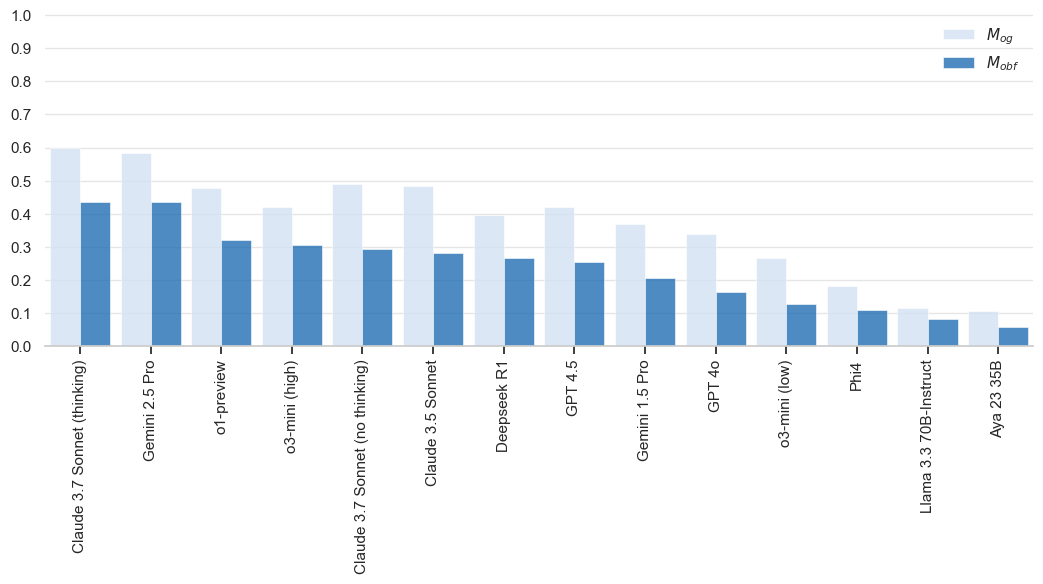

In [876]:
# Main plot
bar_plot(prob_means[prob_means['model_name'].isin(model_order)], ['exact_match_score'], hue='obfuscated', order=model_order, errors=None, ext='svg')

## Robustness metric

In [881]:
# Calculate worst score among permutations

# Ensure we have cases where worst case < average case
subprob_dfs = subquestion_dfs.groupby(['overall_question_n', 'question_n', 'subquestion', 'model_name', 'obfuscated'])['exact_match_score'].agg(['count','std','mean','max','min']).reset_index()
assert subprob_dfs[(subprob_dfs['mean'] > 0.0) & (subprob_dfs['min'] == 0)].shape[0] > 0

# Calculate means at each sub-answer level across permutations
subprob_dfs = subquestion_dfs.groupby(['overall_question_n', 'question_n', 'subquestion', 'model_name', 'obfuscated'])['exact_match_score'].agg(['count','std','mean','max','min']).reset_index()

# Add relevant columns
subprob_dfs['exact_match_score_mean'] = subprob_dfs['mean']
subprob_dfs['exact_match_score_robust'] = subprob_dfs['min']
subprob_dfs['robustness_diff'] = subprob_dfs['exact_match_score_robust'] - subprob_dfs['exact_match_score_mean']
subprob_dfs['robustness_diff_perc'] = subprob_dfs['robustness_diff'] / subprob_dfs['exact_match_score_mean']

# Drop unneeded columns
subprob_dfs = subprob_dfs.drop('mean', axis=1)
subprob_dfs = subprob_dfs.drop('min', axis=1)

# Aggregate to question level, then problem level
subprob_means = subprob_dfs.groupby(['overall_question_n', 'question_n', 'model_name', 'obfuscated'])[['exact_match_score_mean', 'exact_match_score_robust', 'robustness_diff', 'robustness_diff_perc']].agg('mean')
subprob_means = subprob_means.groupby(['overall_question_n', 'model_name', 'obfuscated'])[['exact_match_score_mean', 'exact_match_score_robust', 'robustness_diff', 'robustness_diff_perc']].agg('mean').reset_index()


subprob_means_bm = subprob_means[subprob_means['model_name'].isin(model_order)].groupby(['model_name', 'obfuscated']).mean().reset_index()

#subprob_means_bm['exact_match_robust'] = subprob_means_bm['exact_match_score_mean'] + subprob_means_bm['robustness_diff'] 

subprob_means_bm[subprob_means_bm['obfuscated']].sort_values('exact_match_score_robust', ascending=False)


model_name  obfuscated  overall_question_n  \
7      Claude 3.7 Sonnet (thinking)        True          138.329268   
17                   Gemini 2.5 Pro        True          138.329268   
9                       Deepseek R1        True          138.329268   
25                   o3-mini (high)        True          138.329268   
3                 Claude 3.5 Sonnet        True          138.329268   
5   Claude 3.7 Sonnet (no thinking)        True          138.329268   
23                       o1-preview        True          138.329268   
11                          GPT 4.5        True          138.329268   
15                   Gemini 1.5 Pro        True          138.329268   
13                           GPT 4o        True          138.329268   
21                             Phi4        True          138.329268   
27                    o3-mini (low)        True          138.329268   
19           Llama 3.3 70B-Instruct        True          138.329268   
1                        Aya 23 35B        True          138.329268   

    exact_match_score_mean  exact_match_score_robust  robustness_diff  \
7                 0.437899                  0.237895        -0.200004   
17                0.436215                  0.236054        -0.200161   
9                 0.263214                  0.155542        -0.107672   
25                0.306267                  0.139810        -0.166457   
3                 0.281575                  0.137637        -0.143938   
5                 0.294703                  0.134545        -0.160158   
23                0.324054                  0.133439        -0.190615   
11                0.254466                  0.096460        -0.158006   
15                0.204984                  0.091643        -0.113341   
13                0.163803                  0.050472        -0.113331   
21                0.110292                  0.040855        -0.069437   
27                0.127755                  0.038804        -0.088951   
19                0.081463                  0.023176        -0.058288   
1                 0.056618                  0.013348        -0.043270   

    robustness_diff_perc  
7              -0.676596  
17             -0.667554  
9              -0.618344  
25             -0.769316  
3              -0.758818  
5              -0.774867  
23             -0.793284  
11             -0.826230  
15             -0.752010  
13             -0.892205  
21             -0.830813  
27             -0.867831  
19             -0.851057  
1              -0.863095

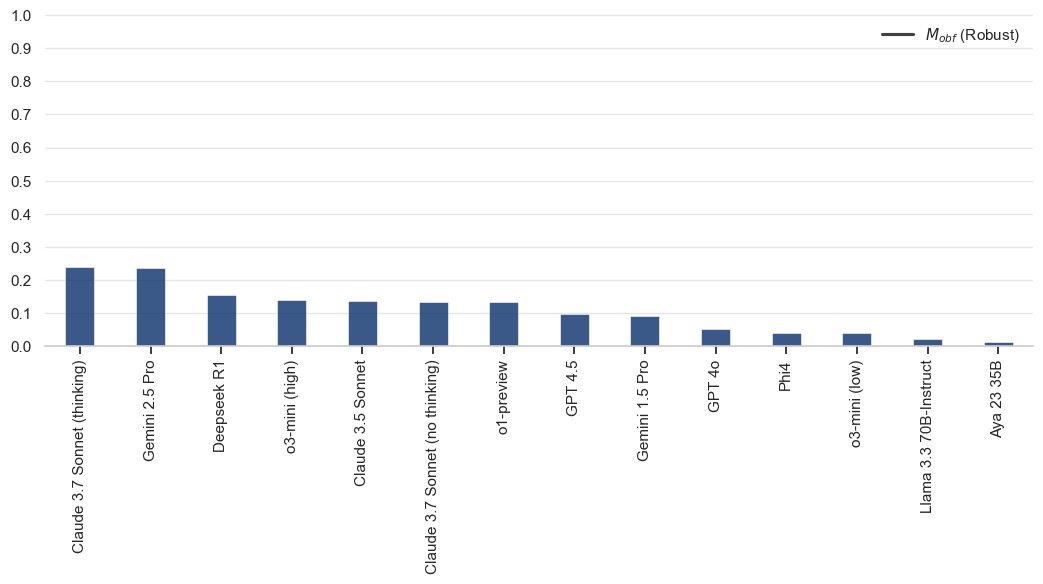

In [882]:
# Plot

model_order_robust = ['Claude 3.7 Sonnet (thinking)', 'Gemini 2.5 Pro', 'Deepseek R1',
       'o3-mini (high)', 'Claude 3.5 Sonnet',
       'Claude 3.7 Sonnet (no thinking)', 'o1-preview', 'GPT 4.5',
       'Gemini 1.5 Pro', 'GPT 4o', 'Phi4', 'o3-mini (low)',
       'Llama 3.3 70B-Instruct', 'Aya 23 35B']

bar_plot(subprob_means_bm[(subprob_means_bm['model_name'].isin(model_order_robust)) & (subprob_means_bm['obfuscated'])], ['exact_match_score_robust'], hue = None, x_col='model_name', order=model_order_robust, col_width=0.41, out_suffix='_robustness', legend_text='$M_{obf}$ (Robust)',  ext='svg')

## Histogram plots

In [883]:
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches
import numpy as np, scipy.stats as st
import random
from matplotlib.ticker import FormatStrFormatter

import matplotlib.colors as mcolors


def hist_per_problem(df, model_names, bsnum=50, limit =5, 
                     metric='exact_match_score', nokde=False, problems=None, figsize=(15, 3), 
                     suffix="",  ext='pdf'):

    if not problems:

        probs = df['overall_question_n'].unique()

        if limit:
            probs = random.sample(list(probs), limit)

    else:
        probs = sorted(problems)
    
    
    #assert len(model_names) % 2 == 0
    fig, axes = plt.subplots(len(probs), len(model_names), figsize=figsize)
        
    #axes = axes.flatten()
    
    colors = ['#FAD8D2', 'lightcyan','aquamarine', 'teal','green', 'purple', 'blue' ]
    edgec = ['#E05205', '#E94E5B', '#1C83DE','dodgerblue', 'steelblue']
    og_color = 'gray' #'#FD9445' #, 'deepskyblue'
    obf_color = 'lightcoral'

    res = {}

    for p, q_num  in enumerate(probs):

        
    
        for i, model_name in enumerate(model_names):

            insp = df[df['overall_question_n'] == q_num]
            this_color = colors[0]
            edge_color = edgec[0]
            
            if model_name in (closed_models):
                this_color = '#DBEAF5'
                edge_color = '#20B0E6'
                
            
    
            #insp = subquestion_dfs[model_name].copy()
            insp = insp[insp['model_name'] == model_name].copy()

            if insp.shape[0] < 1:
                print(f"Skipping {q_num} for model {model_name}")
                continue
    
            # Bootstrap
            #ob_df.groupby(['overall_question_n'])
        
            ob_df = insp[insp['obfuscated']]
            og_df = insp[~insp['obfuscated']]
            
            og_score = og_df[metric].agg('mean')
            obf_score = ob_df[metric].agg('mean')
    
            og_score = np.nan_to_num(og_score)
            obf_score = np.nan_to_num(obf_score)
            
            scores = ob_df.groupby(['obfuscated_question_n'])[metric].agg('mean').values
            scores = [np.nan_to_num(s) for s in scores]
            #print(f"Number of obfuscations: {len(scores)}")
    
    
            # Initialize with [num_bootstrap_iterations, num_problems]
            if bsnum > 0:
                all_questions = insp['overall_question_n'].unique()
                bootstrap = np.zeros((bsnum, len(all_questions)))
                
                #scores = insp.groupby(['obfuscated_question_n'])['exact_match_score'].agg('mean').to_dict()
                # Populate by sampling 1 obfuscated version for each question
                for k, g in enumerate(insp.groupby(['overall_question_n'])):
                    rows = g[1]
                    #print(rows)
                    #obfuscations = rows['obfuscated_question_n'].unique()
                    for j in range(bsnum):
                        #obf_sample = obfuscations[random.randint(0, len(obfuscations))]
                        bootstrap[j,k] = scores[random.randint(0,len(scores)-1)]
                
                # Aggregate by row (score each bootstrapped problems set
                bootstrap = bootstrap.mean(axis=1)
                #print(bootstrap.shape)
                assert bootstrap.shape[0] == bsnum # making sure we aggreate on the correct access
                
                # Now plot 
                scores = bootstrap.squeeze()
            #print(scores.shape)
    
            min_s, max_s = min(scores), max(scores)
    
            #a = scores
            
            intervals = st.t.interval(0.95, len(scores)-1, loc=np.mean(scores), scale=st.sem(scores))
            two_std = intervals[1] - intervals[0]
            #print(f"Conf Int. for {metric} - {intervals}")
    
            res[metric] = (obf_score, intervals)
            
            #subquestion_dfs[model_name].groupby(['obfuscated_question_n'])[list(metrics.values())].agg(['mean','std'])
            ax = axes[p][i]
            #print(scores.shape)
            #print(scores.max())
            #print(scores.min())
            
            #ax.set_xlim(xmin=0, xmax=1) #max(max_s, og_score))
            ax.hist(scores,  bins=12, alpha=.4, ec=f"{edge_color}", lw=.5, color=f"{this_color}") #'lightblue')
            #ax.kde(scores, color = "maroon", label = "_nolegend_")
            
            #ax.set_ylim(ymin=0, ymax=250)
            #ax.set_xlim(xmin=0, xmax=.6) #max(max_score, og_score))
            ymin,ymax  = ax.get_ylim()
            xmin,xmax = ax.get_xlim()
            xmax = max(xmax, max_s, og_score)
            #ax.xaxis.set_ticks(np.arange(ymin, ymax, 0.1))
            
            # KDE

            if not nokde:

                try:
                    kde = gaussian_kde(scores)
                except:
                    print(f"KDE Error {q_num} for model {model_name}")
                    continue
                
                x_range = np.linspace(min_s, max_s, 100)
                max_kde = max(kde(x_range))
                #print(insp.shape[0])
        
                ax2 = ax.twinx()
                ax2.set_ylabel("")
                ax2.yaxis.set_ticks([])
                #ax2.set_xlim(min_s, max_s)
                #ax2.set_ylim(0,25)
                
                #ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
                ax2.plot(x_range, kde(x_range), color=edge_color, lw=2, label=metric, alpha=0.8)
                ymin2, ymax2 = ax2.get_ylim()
                ax2.set_ylim(0, ymax2*1.2)
            
    
            #ax.hlines(xmin=obf_score, xmax=og_score, y=[1], colors=[obf_color], ls='-', lw=30, alpha=0.8)
            
            ax.vlines(x=[og_score], ymin=ymin, ymax=ymax, colors=[og_color], ls='--', lw=2, alpha=0.9)
            ax.vlines(x=[obf_score], ymin=ymin, ymax=ymax, colors=[edge_color], ls='--', lw=2, alpha=0.9)
        
            #ax.set_title(metric)
            #ax.grid(True, which='minor')
            if p == 0:
                ax.set_title(model_name, y=1.12)
            #ax.set_xlabel(f"{model_name}", loc='center')
            ax.set_ylabel("")
            if i == 0:
                ax.set_ylabel(f"Problem {q_num}", rotation=90)
            
            ax.set_yticks(np.arange(0, ymax+0.01, ymax/4))
            #ax.set_yticks(np.arange(0, ymax, ymax/12), minor=True)
            ax.set_xticks(np.arange(0, xmax+0.01, xmax/4))
            #ax.set_xticks(np.arange(0, xmax, xmax/12), minor=True)        
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            #ax.xaxis.set_ticks_position('both')
            #ax.yaxis.set_ticks_position('both')
            if p == 0:
                ax.legend(["Original (Avg.)", "Obfuscated (Avg.)"], loc='upper right', frameon=False)
            #if horizontal and i == 0:
            #    ax.set_ylabel("Frequency")
            #elif not horizontal:
            #    ax.set_ylabel("Frequency")
    
        
            ax.locator_params(axis='x', nbins=10)

    og_patch = mpatches.Patch(color=og_color, label='Original (Avg.)', alpha=.8)
    obf_patch = mpatches.Patch(color=edgec[0], label='Obfuscated (Avg.)', alpha=.8)
    
    # Adjust layout
    plt.tight_layout()
    title=f'Distribution of score values'
    #plt.suptitle(title, y=1.03)
    #plt.legend(handles=[og_patch, obf_patch], loc='upper right', frameon=False)# bbox_to_anchor=(0, 0))
    
    plt.savefig(f'../data/img/hist{suffix}.{ext}', bbox_inches='tight',)
    plt.show()
    return res

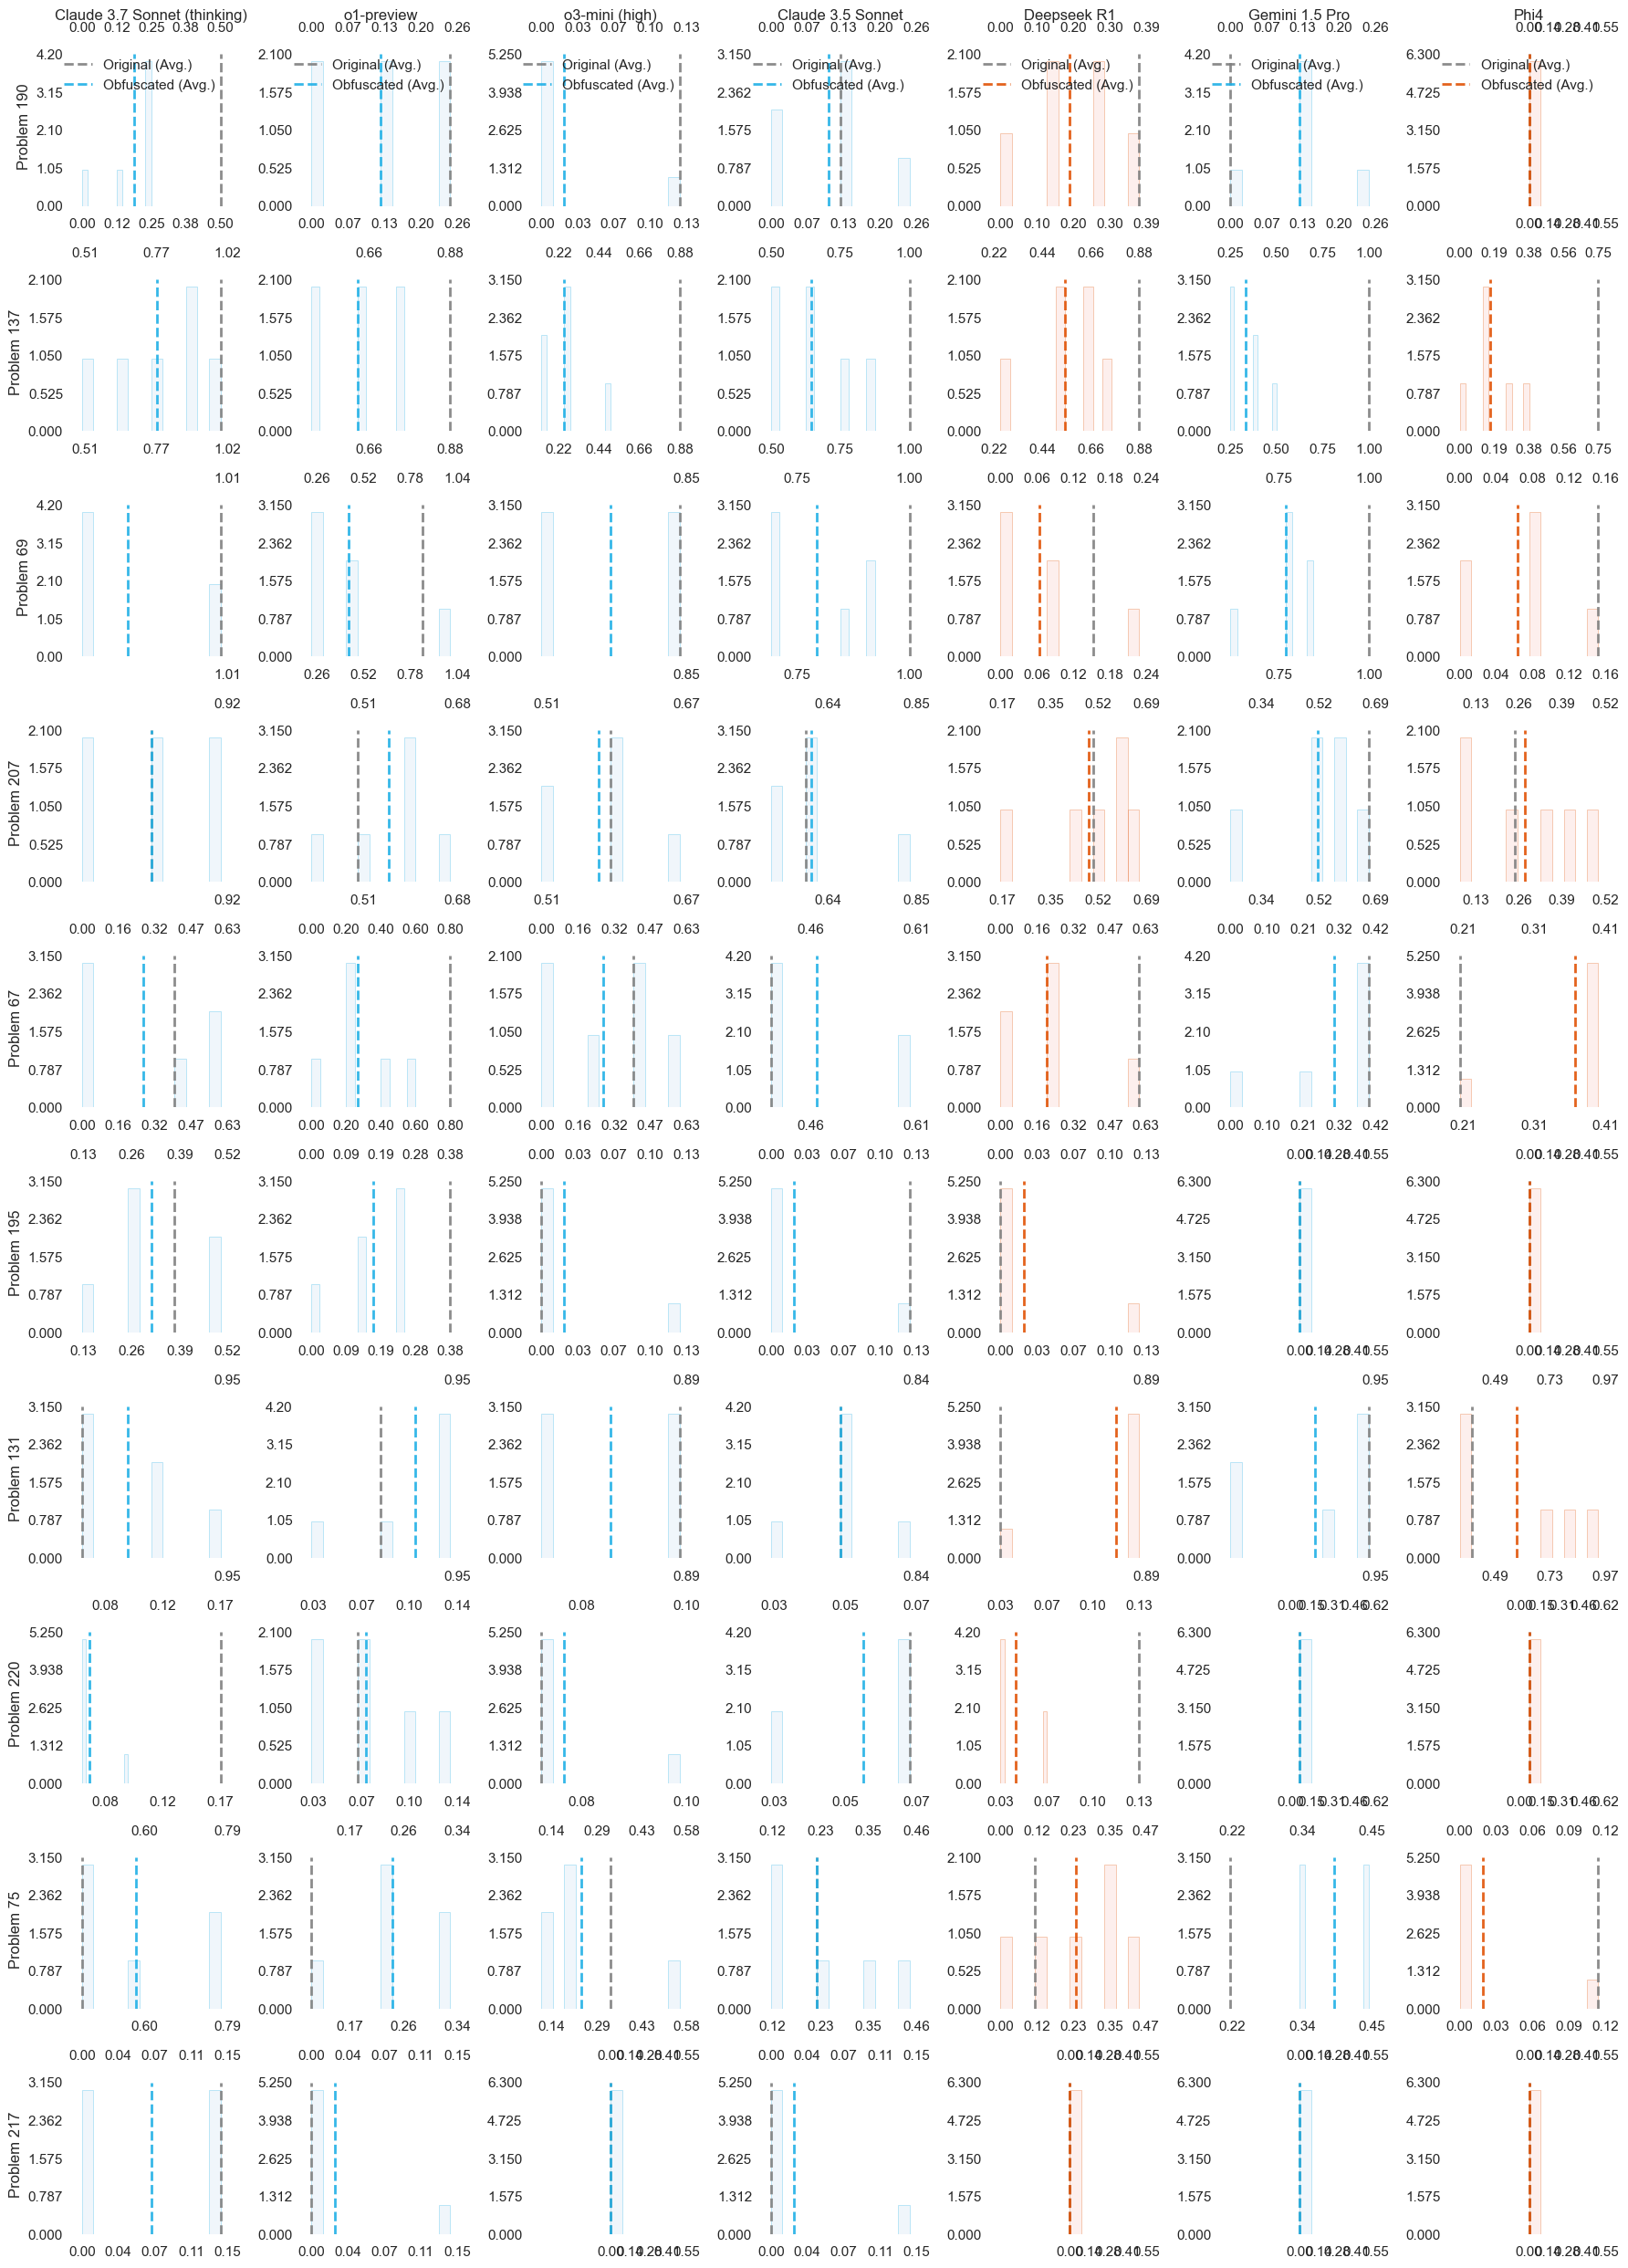

{'exact_match_score': (0.0, (nan, nan))}

In [885]:
# Plot model scores by permutation
hist_details_models = [
 'Claude 3.7 Sonnet (thinking)',
 'o1-preview',
 'o3-mini (high)',
 'Claude 3.5 Sonnet',
 'Deepseek R1',
 'Gemini 1.5 Pro',
 'Phi4',]

hist_problems = [106, 179, 115, 207, 61, 127, 183, 151]
hist_problems = None

hist_per_problem(subquestion_dfs, limit=10, bsnum=0, nokde=True, model_names=hist_details_models,  problems= hist_problems, figsize=(18,25), suffix="_byproblem")

In [886]:
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches
import numpy as np, scipy.stats as st
import random
from matplotlib.ticker import FormatStrFormatter

import matplotlib.colors as mcolors


def plot_multi(df, q_num, model_names, bsnum=50, horizontal=True, nokde=False, metric='exact_match_score', 
               figsize=(15, 3), suffix="",  ext='pdf'):

    if q_num:
        df = df[df['overall_question_n'] == q_num]
    
    plt.rcParams['axes.spines.left'] = True
    plt.rcParams['axes.spines.right'] = True
    plt.rcParams['axes.spines.top'] = True
    plt.rcParams['axes.spines.bottom'] = True
    
    assert len(model_names) % 2 == 0
    if horizontal:
        fig, axes = plt.subplots(2, int(len(model_names)/2), figsize=figsize)
    else:
        fig, axes = plt.subplots(int(len(model_names)/2), 2, figsize=figsize)
        
    axes = axes.flatten()
    
    colors = ['#FAD8D2', 'lightcyan','aquamarine', 'teal','green', 'purple', 'blue' ]
    edgec = ['#E05205', '#E94E5B', '#1C83DE','dodgerblue', 'steelblue']
    og_color = 'gray' #'#FD9445' #, 'deepskyblue'
    obf_color = 'lightcoral'

    res = {}
    
    for i, model_name in enumerate(model_names):
        this_color = colors[0]
        edge_color = edgec[0]
        
        if model_name in closed_models:
            this_color = '#DBEAF5'
            edge_color = '#20B0E6'
            
        

        #insp = subquestion_dfs[model_name].copy()
        insp = df[df['model_name'] == model_name].copy()

        # Bootstrap
        #ob_df.groupby(['overall_question_n'])
    
        ob_df = insp[insp['obfuscated']]
        og_df = insp[~insp['obfuscated']]
        
        og_score = og_df[metric].agg('mean')
        obf_score = ob_df[metric].agg('mean')

        og_score = np.nan_to_num(og_score)
        obf_score = np.nan_to_num(obf_score)
        
        scores = ob_df.groupby(['obfuscated_question_n'])[metric].agg('mean').values
        scores = [np.nan_to_num(s) for s in scores]
        #print(f"Number of obfuscations: {len(scores)}")


        # Initialize with [num_bootstrap_iterations, num_problems]
        if bsnum > 0:
            all_questions = insp['overall_question_n'].unique()
            bootstrap = np.zeros((bsnum, len(all_questions)))
            
            #scores = insp.groupby(['obfuscated_question_n'])['exact_match_score'].agg('mean').to_dict()
            # Populate by sampling 1 obfuscated version for each question
            for k, g in enumerate(insp.groupby(['overall_question_n'])):
                rows = g[1]
                #print(rows)
                #obfuscations = rows['obfuscated_question_n'].unique()
                for j in range(bsnum):
                    #obf_sample = obfuscations[random.randint(0, len(obfuscations))]
                    bootstrap[j,k] = scores[random.randint(0,len(scores)-1)]
            
            # Aggregate by row (score each bootstrapped problems set
            bootstrap = bootstrap.mean(axis=1)
            #print(bootstrap.shape)
            assert bootstrap.shape[0] == bsnum # making sure we aggreate on the correct access
            
            # Now plot 
            scores = bootstrap.squeeze()
        #print(scores.shape)

        min_s, max_s = min(scores), max(scores)

        #a = scores
        
        intervals = st.t.interval(0.95, len(scores)-1, loc=np.mean(scores), scale=st.sem(scores))
        two_std = intervals[1] - intervals[0]
        #print(f"Conf Int. for {metric} - {intervals}")

        res[metric] = (obf_score, intervals)
        
        #subquestion_dfs[model_name].groupby(['obfuscated_question_n'])[list(metrics.values())].agg(['mean','std'])
        ax = axes[i]
        
        #ax.set_xlim(xmin=0, xmax=1) #max(max_s, og_score))
        ax.hist(scores,  bins=12, alpha=.4, ec=f"{edge_color}", lw=.5, color=f"{this_color}") #'lightblue')
        #ax.kde(scores, color = "maroon", label = "_nolegend_")
        
        #ax.set_ylim(ymin=0, ymax=250)
        #ax.set_xlim(xmin=0, xmax=.6) #max(max_score, og_score))
        ymin,ymax  = ax.get_ylim()
        xmin,xmax = ax.get_xlim()
        xmax = max(xmax, max_s, og_score)
        #ax.xaxis.set_ticks(np.arange(ymin, ymax, 0.1))
        
        # KDE

        if not nokde:
        
            kde = gaussian_kde(scores)
            
            x_range = np.linspace(min_s, max_s, 100)
            max_kde = max(kde(x_range))
            #print(insp.shape[0])
    
            ax2 = ax.twinx()
            ax2.set_ylabel("")
            ax2.yaxis.set_ticks([])
            #ax2.set_xlim(min_s, max_s)
            #ax2.set_ylim(0,25)
            
            #ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
            ax2.plot(x_range, kde(x_range), color=edge_color, lw=2, label=metric, alpha=0.8)
            ymin2, ymax2 = ax2.get_ylim()
            ax2.set_ylim(0, ymax2*1.1)
        

        #ax.hlines(xmin=obf_score, xmax=og_score, y=[1], colors=[obf_color], ls='-', lw=30, alpha=0.8)
        
        ax.vlines(x=[og_score], ymin=ymin, ymax=ymax, colors=[og_color], ls='--', lw=2, alpha=0.9)
        ax.vlines(x=[obf_score], ymin=ymin, ymax=ymax, colors=[edge_color], ls='--', lw=2, alpha=0.9)
    
        #ax.set_title(metric)
        #ax.grid(True, which='minor')
        ax.set_title(model_name, y=1.12, fontsize=18)
        #ax.set_xlabel(f"{model_name}", loc='center')
        ax.set_ylabel("Frequency", fontsize=15)
        if i // (len(model_names)/2) > 0:
            ax.set_xlabel("Exact Match", fontsize=15)
        else:
            ax.set_xlabel("")
        
        ax.set_yticks(np.arange(0, ymax, ymax/4))
        ax.set_yticks(np.arange(0, ymax, ymax/12), minor=True)
        ax.set_xticks(np.arange(0, xmax+0.01, xmax/4))
        ax.set_xticks(np.arange(0, xmax+0.01, xmax/12), minor=True)        
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.xaxis.set_ticks_position('bottom') # can be both
        ax.yaxis.set_ticks_position('none')
        yl = ax.get_yticklabels()
        ax.set_yticklabels(["" for _ in range(len(yl))])
        ax.legend(["Original", "Bootsrapped"], loc='upper right', frameon=False)
        #if horizontal and i == 0:
        #    ax.set_ylabel("Frequency")
        #elif not horizontal:
        #    ax.set_ylabel("Frequency")

    
        ax.locator_params(axis='x', nbins=10)

    og_patch = mpatches.Patch(color=og_color, label='Original', alpha=.8)
    obf_patch = mpatches.Patch(color=edgec[0], label='Bootsrapped', alpha=.8)
    
    # Adjust layout
    plt.tight_layout()
    title=f'Distribution of score values'
    #plt.suptitle(title, y=1.03)
    #plt.legend(handles=[og_patch, obf_patch], loc='upper right', frameon=False)# bbox_to_anchor=(0, 0))
    
    plt.savefig(f'../data/img/hist{suffix}.{ext}', bbox_inches='tight',)
    plt.show()
    return res

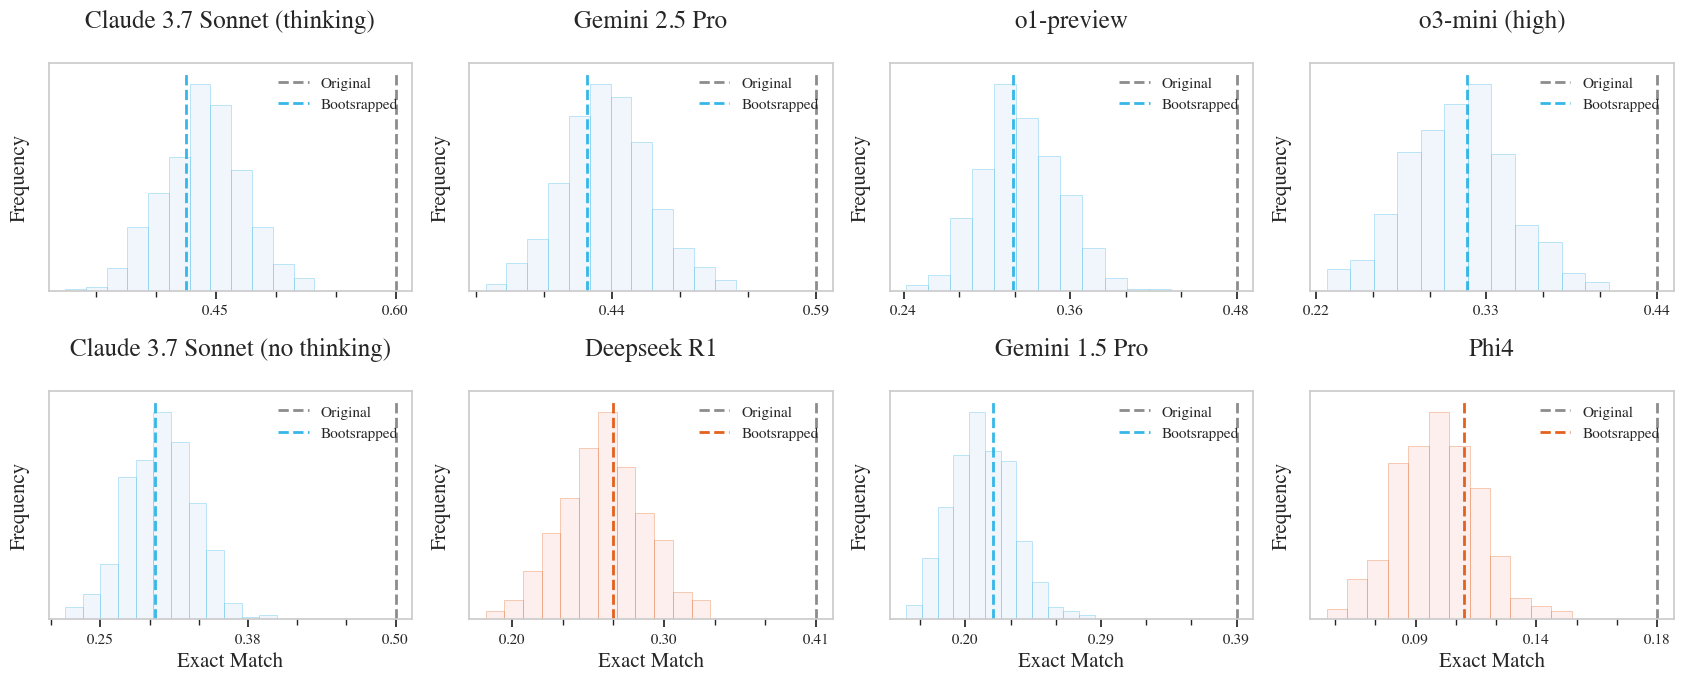

{'exact_match_score': (0.11068447412353923,
  (0.09913473099128779, 0.10190831650255257))}

In [890]:
plt_models = [
 'Claude 3.7 Sonnet (thinking)',
 'Gemini 2.5 Pro',
 'o1-preview',
 'o3-mini (high)',
 'Claude 3.7 Sonnet (no thinking)',
 'Deepseek R1',
 'Gemini 1.5 Pro',
 'Phi4']
              
plt.rcParams["font.family"] = 'Times'
plot_multi(subquestion_dfs, q_num=None, bsnum=500, model_names=plt_models, horizontal=True, figsize=(17,7), nokde=True, ext='pdf')

In [888]:
def bar_plot_diff(filtered, q_num = None, metrics=metrics):

    prob = "All"
    if q_num:
        filtered = filtered[filtered['overall_question_n'] == q_num]
        prob = q_num

    fig, ax = plt.subplots(1, len(metrics), layout="constrained", figsize=(15, 6))
    for i, metric_details in enumerate(metrics.items()):
        plot_metric = metric_details[1]

        if len(metrics) == 1:
            this_ax = ax
        else:
            this_ax = ax[i]
        # Create and display the plot
        axis = sns.barplot(x="model_name",
                    y=f"{plot_metric}_diff",
                    #hue="obfuscated",
                    data=filtered,
                    ax=this_ax,
                    hue="model_name",
                    palette="Set2",
                    width=0.5)
        #axis.bar_label(axis, rotation='vertical')
        this_ax.tick_params(axis='x', rotation=90)

        # break
    

    title = f"(Difference in accuracy by model. Problem: {prob}"
    plt.title(title, size=20)
    plt.legend(loc="upper left")
    #plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
    plt.savefig(f'{title}.png', bbox_inches='tight')
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


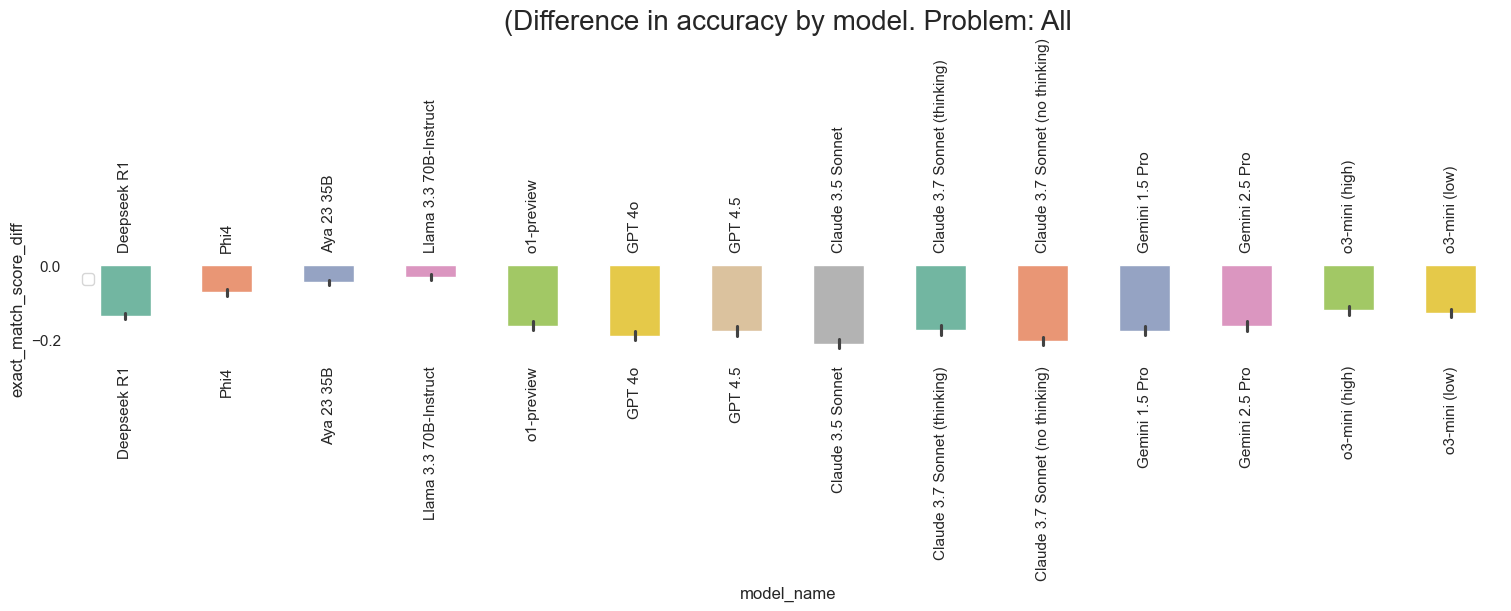

In [889]:
# Plot diff
bar_plot_diff(merged, metrics={'Exact Match':'exact_match_score'})

## Heatmaps of scores by problem

In [1013]:
# Create custom colormap
import matplotlib
from matplotlib import colors, cm
from matplotlib.pyplot import subplots
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

In [1014]:


def plot_versions(data, all_models, metric, suffix="", prob_size=1, mask_below = -0.1, mask_above = 1, figsize=(25, 6),
                  limit=None, c=newcmp, nolegend=False, ext='pdf', no_ylabel=False, ylabel=r'$\Delta_{obf}$'):
    
    def plt_img(df, all_models, metric, ax):
        gcols = ['overall_question_n', 'obfuscated_question_n_obf', ]
        diffs = []
        
        #metric = 'exact_match_score' #'rouge_score'
        for i, mn in enumerate(all_models):
            #print(mn)
            tmp = df[df['model_name'] == mn].copy()
            gcols = ['obfuscated_question_n_obf']
            means = tmp.groupby(gcols)[f"{metric}"].mean().reset_index().sort_values(by=gcols)[metric].values

            
            # Mask poor performance 
            means_og = tmp.groupby('obfuscated_question_n_obf')["exact_match_score_og"].mean().reset_index().sort_values(by=gcols)["exact_match_score_og"].values
            means[(means_og <= mask_below).astype(bool)] = np.nan
            means[(means_og > mask_above).astype(bool)] = np.nan
            #print(len(means))
            #means = tmp.groupby(['overall_question_n', 'question_n','subquestion','model_name'])[metric].mean().reset_index()
            
            if means.shape[0] < 1:
                print(f"Skipping {mn}")
                continue
            diffs.append(means[:20])
            
        diffs = np.array(diffs)
        if diffs.ndim == 1:
            len_diff = len(diffs)
        else:
            len_diff = len(diffs[0])
        #print(len_diff)
            
    
        # create a single norm to be shared across all images
        norm = colors.Normalize(vmin=-.9, vmax=.9)
        
        
        #fig, ax = subplots(figsize=(40, 20))
        #ax.yt
        cmap = matplotlib.colormaps.get_cmap(c) #(rand_normal_y_norm)
        cmap.set_bad(color='green')
        img = ax.imshow(diffs, norm=norm, aspect=len_diff*1.5, cmap=cmap, interpolation='nearest')
        
        return img, norm, cmap

    
    all_problems = set(data['overall_question_n'].unique())

    # Only take problems with enough data
    problems = []
    for p in all_problems:
        if data[data['overall_question_n'] == p].shape[0] > prob_size:
            problems.append(p)
    if limit:
        problems = problems[:limit]

    gridspec = {'width_ratios': [1 for _ in  range(len(problems))] + [0.4]}
    #print(f"{len(problems)} problems will be included")
    fig, axes = subplots(1, len(problems) + 1, figsize=figsize, gridspec_kw=gridspec)


    for i, prob in enumerate(problems):
        subset = data[data['overall_question_n'] == prob].copy()
        img, norm, cmap = plt_img(subset, all_models, metric, axes[i])
        axes[i].set_title(f"{prob:5d}", rotation=90, fontsize=30)
        axes[i].set_yticks([],[])
        axes[i].set_xticks([],[])

    #plt.ylabel(all_models)
    axes[0].set_yticks(list(range(len(all_models))), [f"{m}  " for m in all_models], fontsize=30)
    if no_ylabel:
        axes[0].set_yticks(list(range(len(all_models))), [f"{i}" for i, _ in enumerate(all_models)], fontsize=30)
    axes[0].set_ylabel("Models", fontsize=30)

    # Set legend over fake axis
    axes[-1].spines['top'].set_visible(True)
    axes[-1].spines['right'].set_visible(True)
    axes[-1].spines['bottom'].set_visible(True)
    axes[-1].spines['left'].set_visible(True)
    axes[-1].set_yticks([],[])
    axes[-1].set_xticks([],[])
    if not nolegend:
        cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=c), ax=axes[-1], fraction=.99, pad=.9)
        cbar.ax.tick_params(labelsize=30) 
        cbar.ax.set_ylabel(ylabel, fontsize=34)

    #axes[1].update_traces.xgap(1)
    title = f"Problem Number"
    #fig.title(title, loc='center')
    
    plt.savefig(f'../data/img/heatmap{suffix}.{ext}', bbox_inches='tight')
    plt.show()


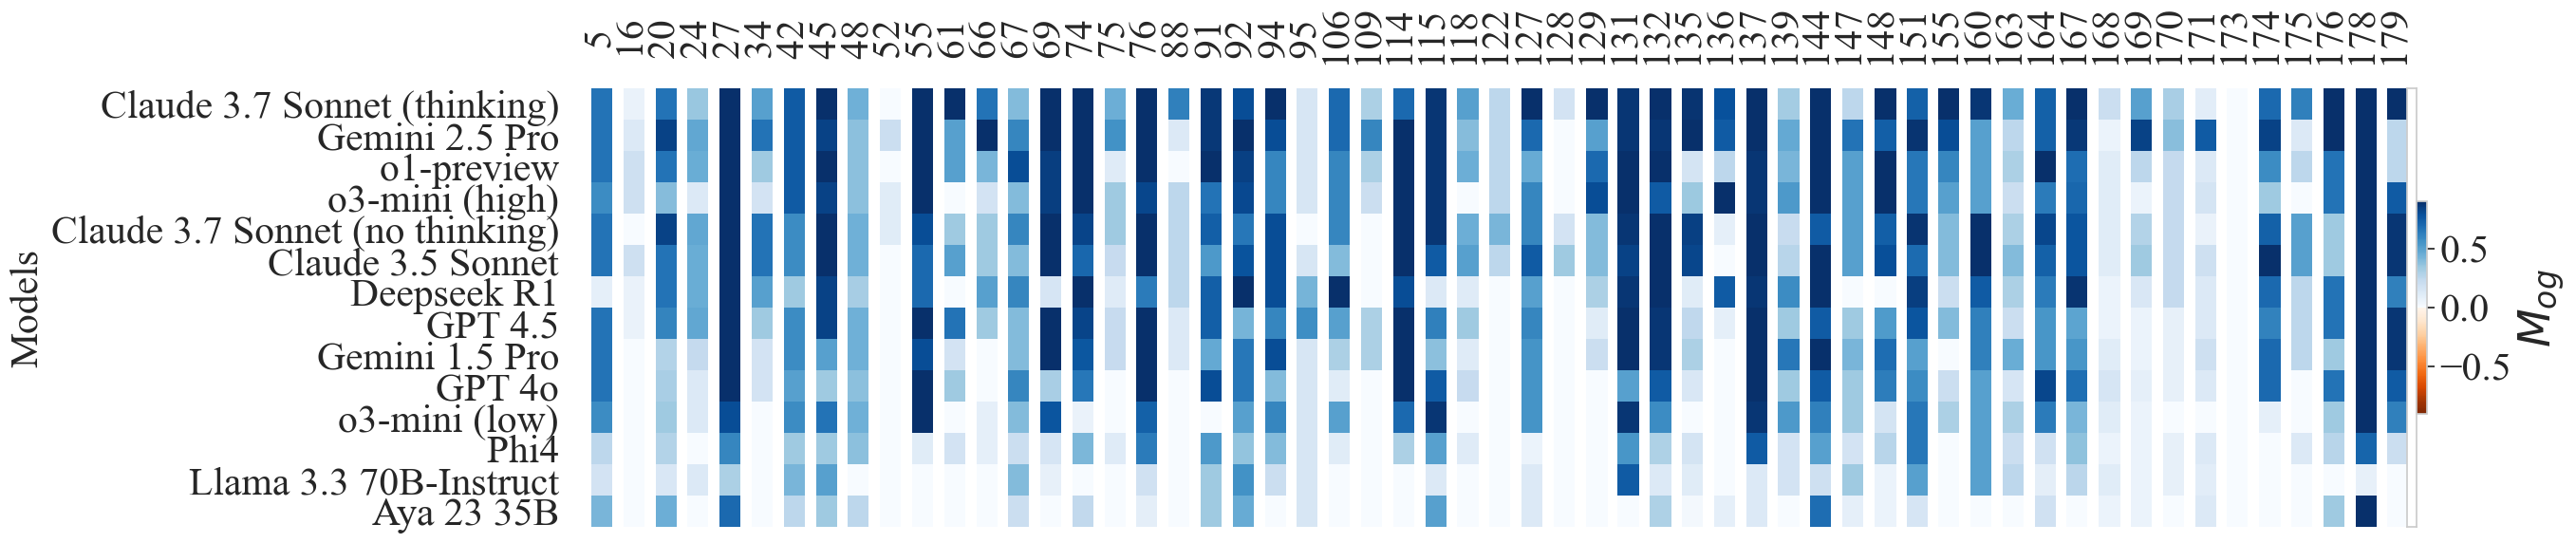

In [1021]:
# Aboslute score without obfuscation for subset of problems
limit_prob = 57
plot_versions(merged_means, model_order, 'exact_match_score_og',
              suffix=f"og_{limit_prob}",
              prob_size=10,
              mask_below=-100,
              limit=limit_prob, c=newcmp, ylabel=r'$M_{og}$')

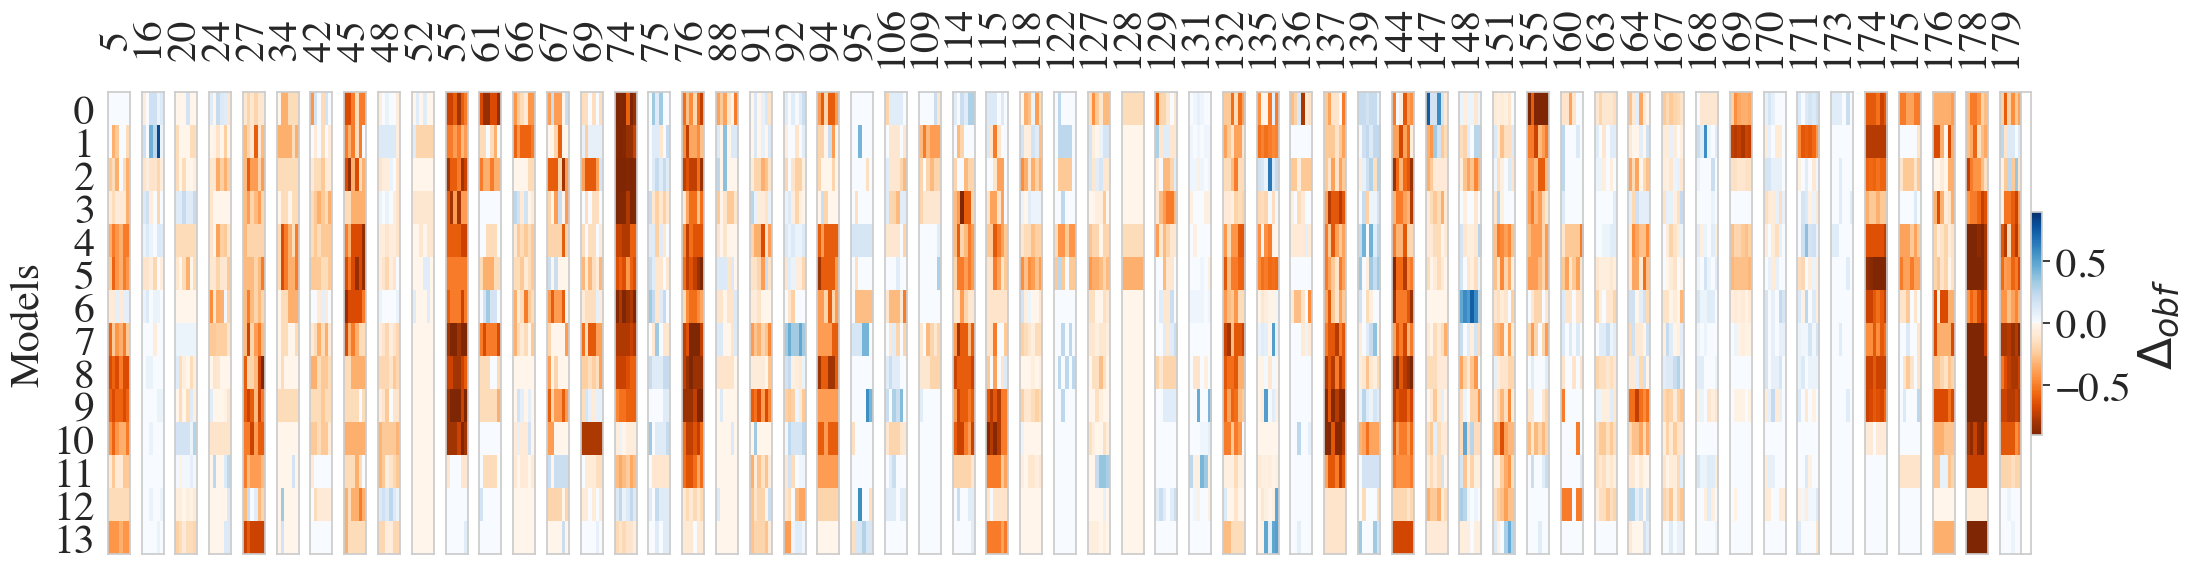

In [903]:
# Score diff subset of problems
limit_prob = 57
plot_versions(merged_means, model_order, 'exact_match_score_diff',
              suffix=f"delta_obf_{limit_prob}",
              prob_size=10,
              mask_below=-100,
              no_ylabel=True,
              limit=limit_prob, c=newcmp, ext='pdf')

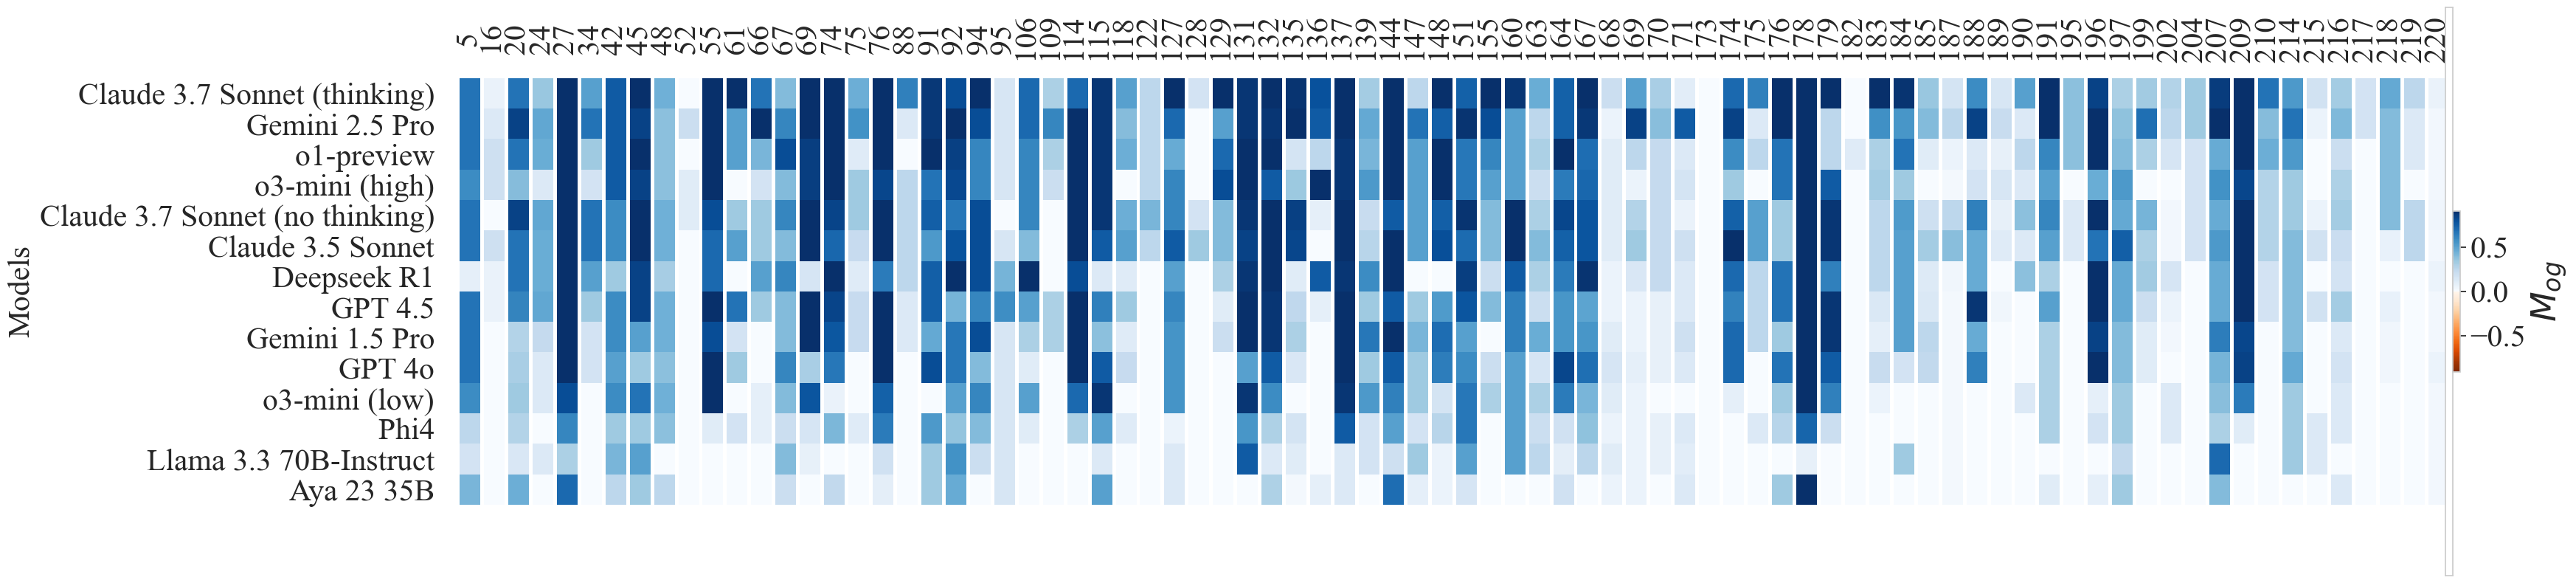

In [1022]:
# Plot all problems
plot_versions(merged_means, model_order, 'exact_match_score_og',
              suffix="delta_og_all",
              prob_size=10,
              mask_below=-100,
              figsize=(35,10),
              no_ylabel=False,
              ylabel=r'$M_{og}$',
              ext='svg',
              limit=None, c=newcmp)

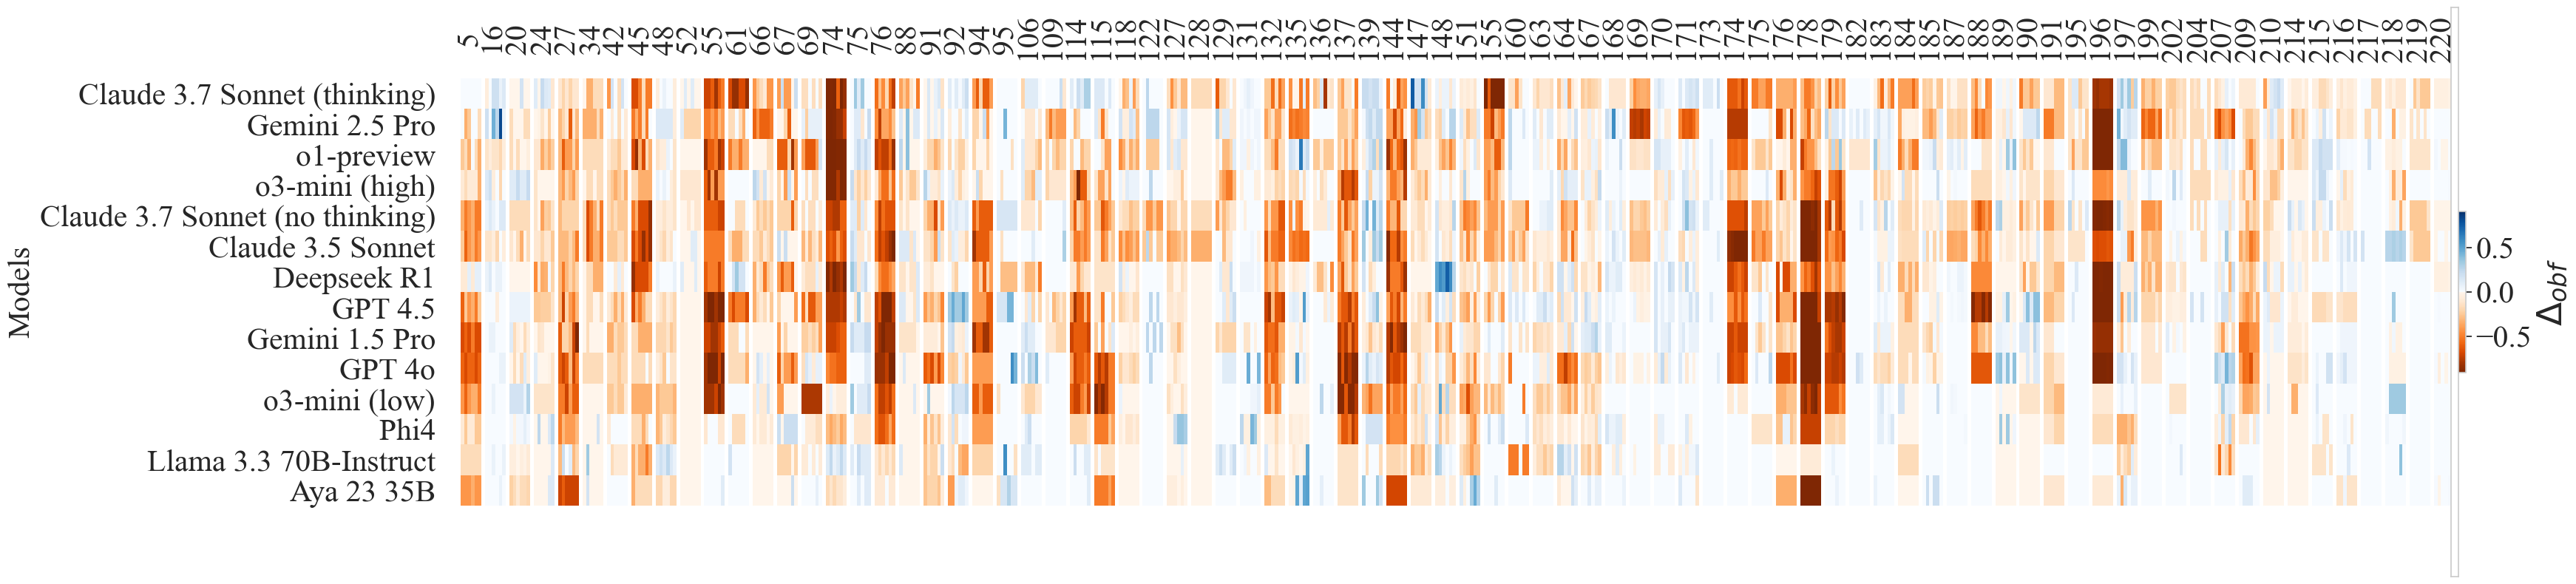

In [1018]:
# Plot all problems
plot_versions(merged_means, model_order, 'exact_match_score_diff',
              suffix="delta_diff_all",
              prob_size=10,
              mask_below=-100,
              figsize=(35,10),
              no_ylabel=False,
              ext='svg',
              limit=None, c=newcmp)

## Add Metadata

In [909]:
metadata = pd.read_csv("../data/past-exam-papers.csv")
metadata.set_index("Overall Question Number", inplace=True)

subjects_map = {
    "Co": "Compounding",
    "Mo": "Morphology",
    "Nu": "Numbers",
    "Ph": "Phonology",
    "Pho": "Phonology",
    "Se": "Semantics",
    "Sy": "Syntax",
}

difficulty_order = {
    "Breakthrough": 0,
    "Foundation": 1,
    "Intermediate": 2,
    "Advanced": 3,
    "Round2": 4,
}
r_difficulty_order = {
    "Breakthrough": 4,
    "Foundation": 3,
    "Intermediate": 2,
    "Advanced": 1,
    "Round2": 0,
}
subjects_order = [
    "Phonology",
    "Semantics",
    "Syntax",
    "Morphology",
    "Numbers",
    "Compounding",

]
frequency_order = [
    "Computational",
    "Text",
    "Monolingual",
    "Match-up",
    "Pattern",
    "Rosetta",
]



temp = metadata.merge(prob_means, left_index=True, right_on="overall_question_n")

temp["Digital Support"] = temp["Digital Support"].apply(
    lambda x: ast.literal_eval(x)
)
temp["Digital Support"] = temp["Digital Support"].apply(
    lambda x: np.mean([float(i) for i in x])
)

temp["Speakers"] = temp["Speakers"].apply(lambda x: ast.literal_eval(x))
temp["Speakers"] = temp["Speakers"].apply(
    lambda x: np.mean([float(i) for i in x])
)
temp["log10_Speakers"] = temp["Speakers"].apply(
    lambda x: np.log10(x) if x > 0 else 0
)

temp["Level and Score"] = temp["Level and Score"].apply(
    lambda x: ast.literal_eval(x)
)
temp["Level and Score"] = temp["Level and Score"].apply(lambda x: x[-1][0])

temp["Question Format"] = temp["Question Format"].apply(
    lambda x: ast.literal_eval(x)
)
temp["Question Format"] = temp["Question Format"].apply(lambda x: x[0])
temp["Subjects"] = temp["Subjects"].apply(lambda x: ast.literal_eval(x))
temp["Subjects"] = temp["Subjects"].apply(lambda x: x[0])
temp["Subjects"] = temp["Subjects"].map(subjects_map)

prob_metadata = temp.copy()


temp = metadata.merge(merged_means, left_index=True, right_on="overall_question_n")

temp["Digital Support"] = temp["Digital Support"].apply(
    lambda x: ast.literal_eval(x)
)
temp["Digital Support"] = temp["Digital Support"].apply(
    lambda x: np.mean([float(i) for i in x])
)

temp["Speakers"] = temp["Speakers"].apply(lambda x: ast.literal_eval(x))
temp["Speakers"] = temp["Speakers"].apply(
    lambda x: np.mean([float(i) for i in x])
)
temp["log10_Speakers"] = temp["Speakers"].apply(
    lambda x: np.log10(x) if x > 0 else 0
)

temp["Level and Score"] = temp["Level and Score"].apply(
    lambda x: ast.literal_eval(x)
)
temp["Level and Score"] = temp["Level and Score"].apply(lambda x: x[-1][0])

temp["Question Format"] = temp["Question Format"].apply(
    lambda x: ast.literal_eval(x)
)
temp["Question Format"] = temp["Question Format"].apply(lambda x: x[0])
temp["Subjects"] = temp["Subjects"].apply(lambda x: ast.literal_eval(x))
temp["Subjects"] = temp["Subjects"].apply(lambda x: x[0])
temp["Subjects"] = temp["Subjects"].map(subjects_map)


merge_means_metadata = temp.copy()

## Plots with metadata

In [908]:
def trend_plot(filtered, x_col ='Level and Score', y_col = 'exact_match_score', out_suffix=""):
    prob = "All"

    x = range(len(filtered.columns))

    for v in x:
        plt.axvline(x=v, color='black', linestyle='--', linewidth=1, alpha=.3) # 1952

    # Create and display the plot

    for idx in filtered.index:
        
        ax = plt.plot(x,
                    filtered.loc[idx],
                    label = idx,
                    marker='o', 
                    alpha=.8,
                    linewidth=2,
                     )
    
    title = f"by model. Problem: {prob}. {out_suffix}"
    plt.grid(color='gray', alpha=.2, axis='y')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.legend()
    plt.savefig(f'../data/img/trend{out_suffix}.png', bbox_inches='tight')
    plt.show()

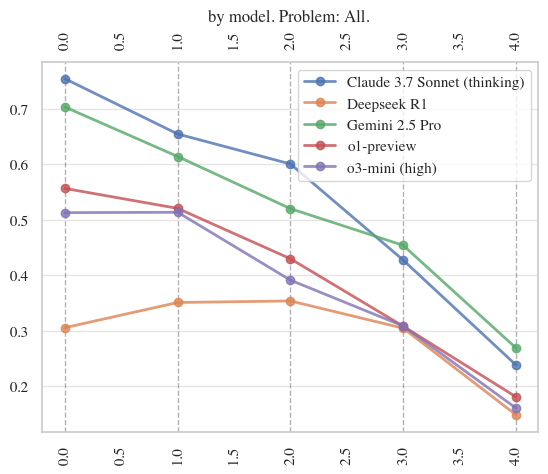

In [914]:
# Does the performance drop with dificulty - non obfuscated?  Seems like it
reasoning_models = ['Claude 3.7 Sonnet (thinking)',
 'Gemini 2.5 Pro',
 'o1-preview',
 'Deepseek R1',
 'o3-mini (high)',]
tmp = prob_metadata[(prob_metadata['model_name'].isin(reasoning_models)) & (prob_metadata['obfuscated'])].groupby(['model_name', 'Level and Score'])['exact_match_score'].mean().unstack()
difficulty_sorted = [k for k, _ in sorted(difficulty_order.items(), key=lambda x: x[1])]
trend_plot(tmp[difficulty_sorted], ) 

In [912]:
# Does the performance gap drop with dificulty - Not really no pattern emerges
merge_means_metadata[(merge_means_metadata['model_name'].isin(reasoning_models))].groupby(['Level and Score','model_name', ])['exact_match_score_diff'].mean().unstack()

model_name       Claude 3.7 Sonnet (thinking)  Deepseek R1  Gemini 2.5 Pro  \
Level and Score                                                              
Advanced                                -0.20        -0.16           -0.17   
Breakthrough                            -0.17        -0.26           -0.19   
Foundation                              -0.12        -0.16           -0.14   
Intermediate                            -0.11        -0.06           -0.05   
Round2                                  -0.15        -0.11           -0.15   

model_name       o1-preview  o3-mini (high)  
Level and Score                              
Advanced              -0.18           -0.11  
Breakthrough          -0.27           -0.33  
Foundation            -0.18           -0.19  
Intermediate          -0.17           -0.13  
Round2                -0.09           -0.05

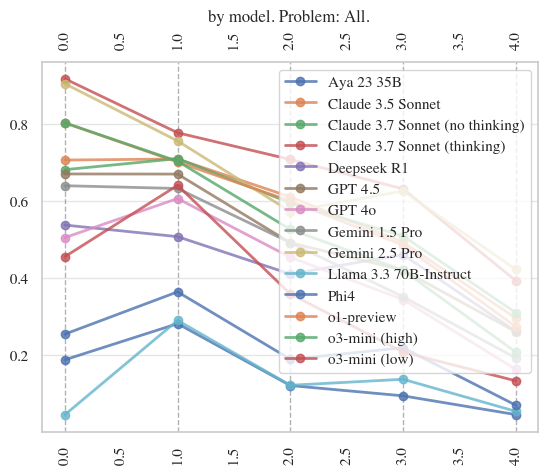

In [916]:
# Does the performance drop with dificulty - non obfuscated? 

tmp = prob_metadata[(prob_metadata['model_name'].isin(model_order)) & (~prob_metadata['obfuscated'])].groupby(['model_name', 'Level and Score'])['exact_match_score'].mean().unstack()
difficulty_sorted = [k for k, _ in sorted(difficulty_order.items(), key=lambda x: x[1])]
trend_plot(tmp[difficulty_sorted], ) 
#trend_plot(prob_metadata[(prob_metadata['obfuscated']) & (prob_metadata['model_name'].isin(all_models + ['o1-preview']))], x_col="Level and Score", hue='model_name')


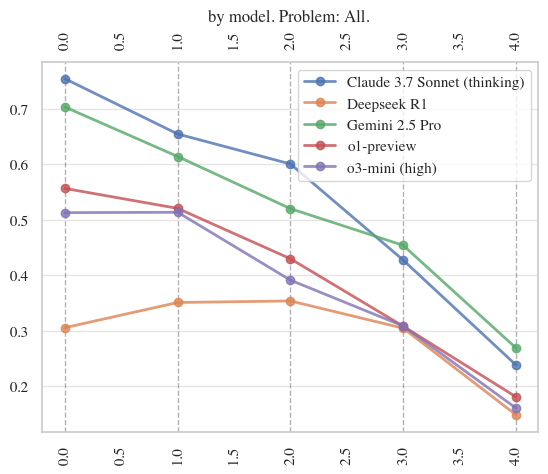

In [921]:
#Same when obfuscated? 

tmp = prob_metadata[(prob_metadata['model_name'].isin(model_order)) & (prob_metadata['obfuscated'])].groupby(['model_name', 'Level and Score'])['exact_match_score'].mean().unstack()
difficulty_sorted = [k for k, _ in sorted(difficulty_order.items(), key=lambda x: x[1])]
trend_plot(tmp[difficulty_sorted], ) 
#trend_plot(prob_metadata[(prob_metadata['obfuscated']) & (prob_metadata['model_name'].isin(all_models + ['o1-preview']))], x_col="Level and Score", hue='model_name')


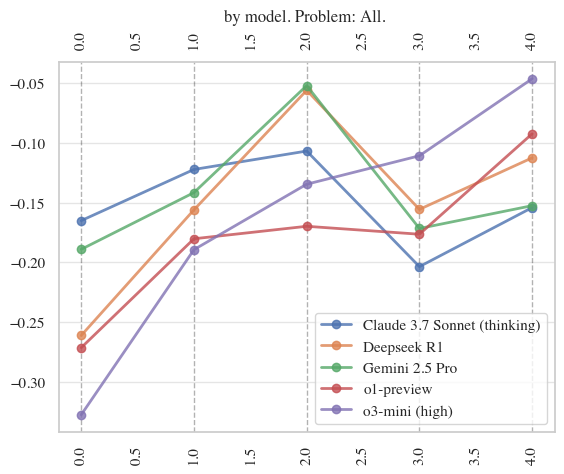

In [922]:
# Does the performance diff change with dificulty? 

tmp = merge_means_metadata[(merge_means_metadata['model_name'].isin(reasoning_models))].groupby(['model_name', 'Level and Score'])['exact_match_score_diff'].mean().unstack()
difficulty_sorted = [k for k, _ in sorted(difficulty_order.items(), key=lambda x: x[1])]
trend_plot(tmp[difficulty_sorted], ) 
#trend_plot(prob_metadata[(prob_metadata['obfuscated']) & (prob_metadata['model_name'].isin(all_models + ['o1-preview']))], x_col="Level and Score", hue='model_name')


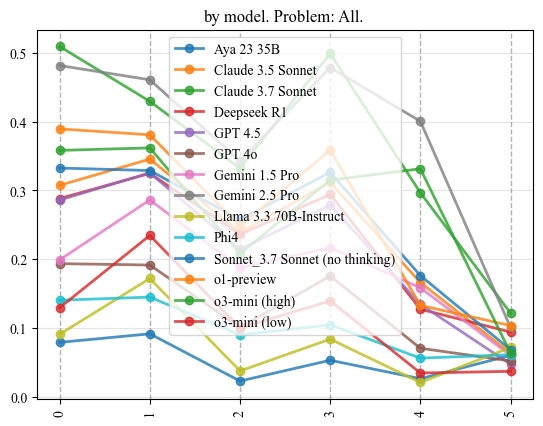

In [68]:
#Change by Subjects? 

tmp = prob_metadata[(prob_metadata['model_name'].isin(model_order)) & (prob_metadata['obfuscated'])].groupby(['model_name', "Subjects"])['exact_match_score'].mean().unstack()
#difficulty_sorted = [k for k, _ in sorted(subjects_order, key=lambda x: x[1])]
trend_plot(tmp[subjects_order], ) 
#trend_plot(prob_metadata[(prob_metadata['obfuscated']) & (prob_metadata['model_name'].isin(all_models + ['o1-preview']))], x_col="Level and Score", hue='model_name')


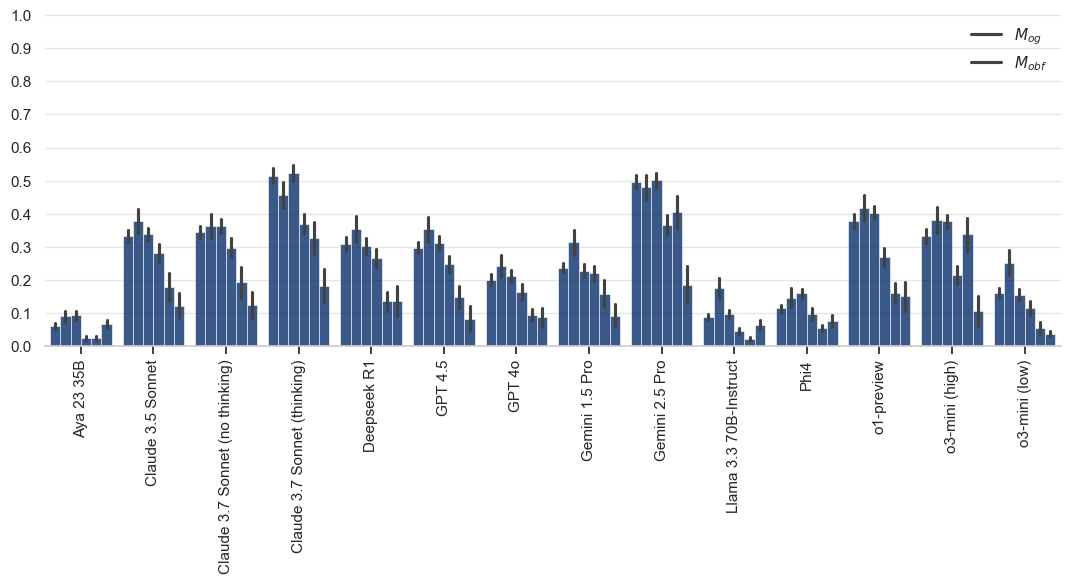

In [923]:
bar_plot(prob_metadata[prob_metadata['model_name'].isin(model_order)], hue="Subjects", x_col='model_name', plot_metric=['exact_match_score'])

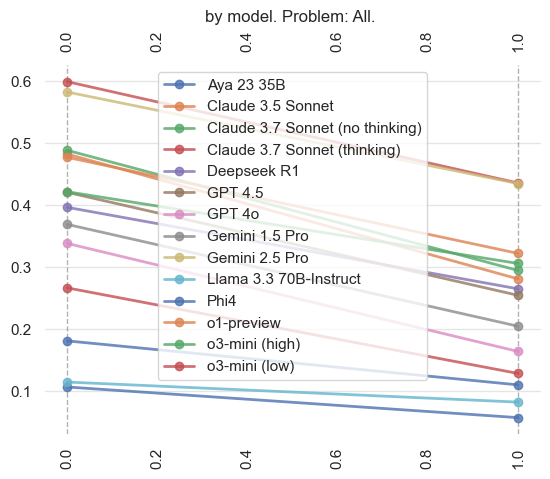

In [925]:
# Drop by model 

tmp = prob_metadata[(prob_metadata['model_name'].isin(model_order))].groupby(['model_name', 'obfuscated'])['exact_match_score'].mean().unstack()
obfuscated_sorted = [True, False]
trend_plot(tmp ) 
#trend_plot(prob_metadata[(prob_metadata['obfuscated']) & (prob_metadata['model_name'].isin(all_models + ['o1-preview']))], x_col="Level and Score", hue='model_name')


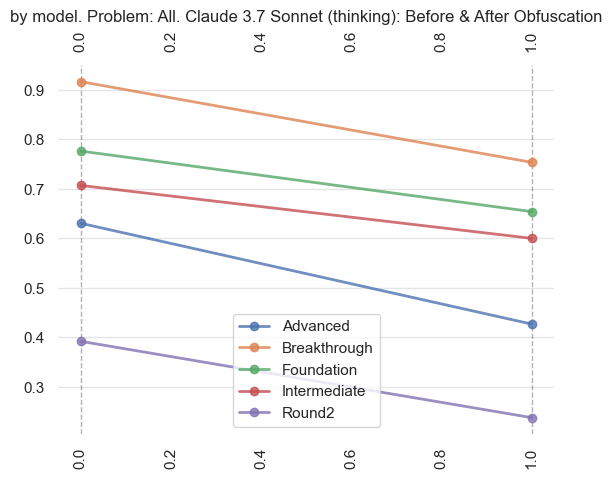

In [926]:
m = 'Claude 3.7 Sonnet (thinking)'
tmp = prob_metadata[(prob_metadata['model_name'] == m)].groupby(['Level and Score', 'obfuscated'])['exact_match_score'].mean().unstack()
obfuscated_sorted = [True, False]
trend_plot(tmp, out_suffix=m + ": Before & After Obfuscation" ) 

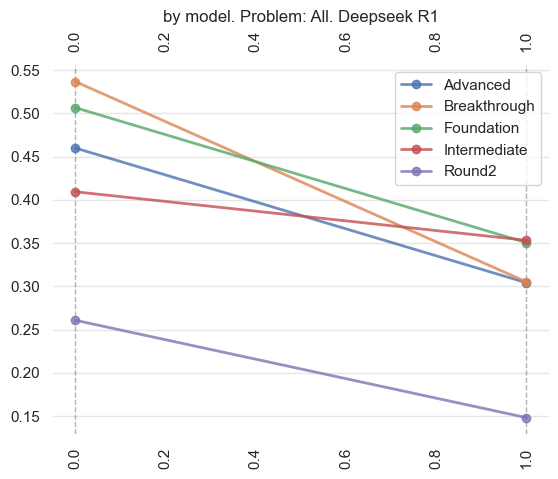

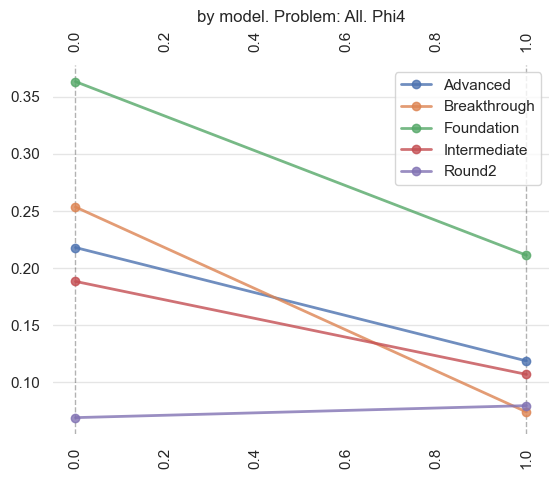

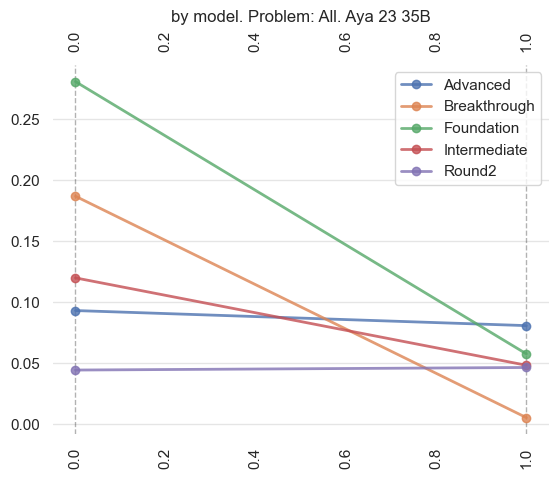

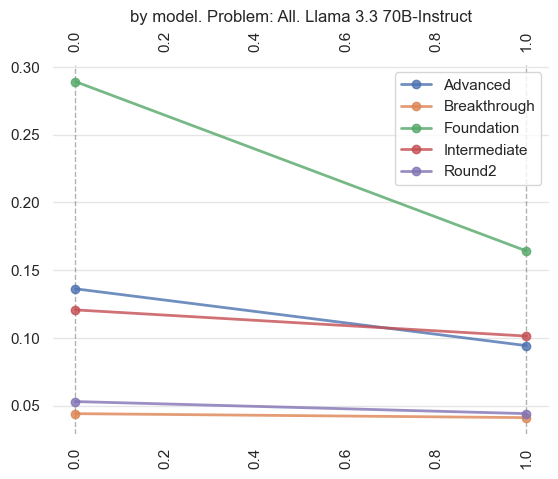

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


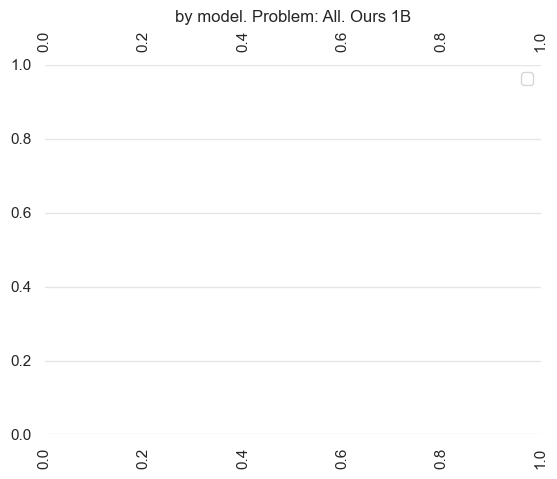

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


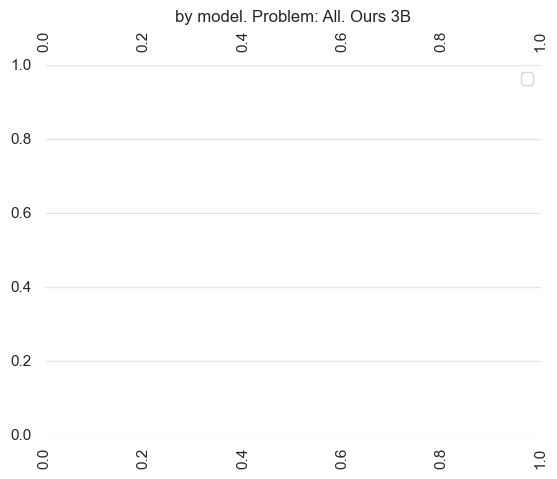

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


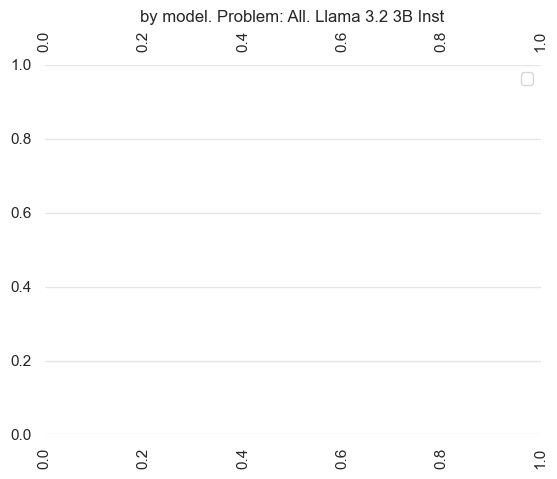

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


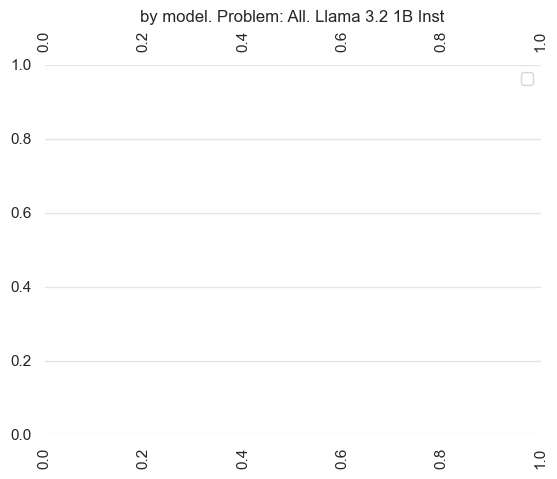

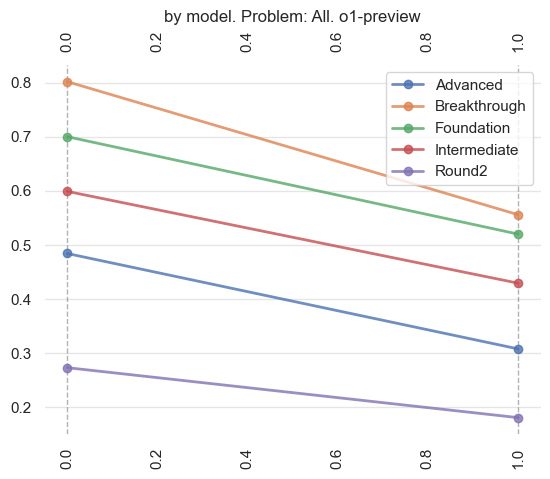

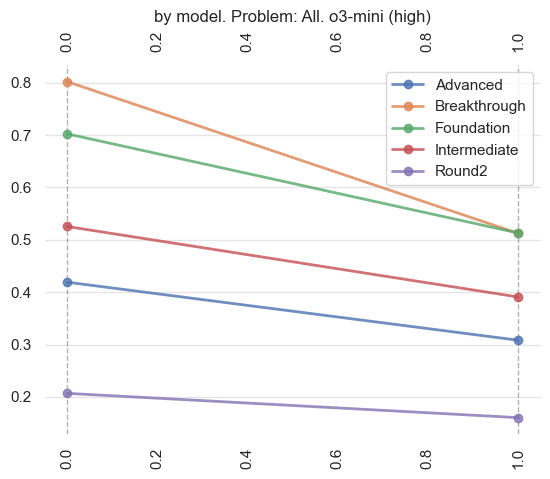

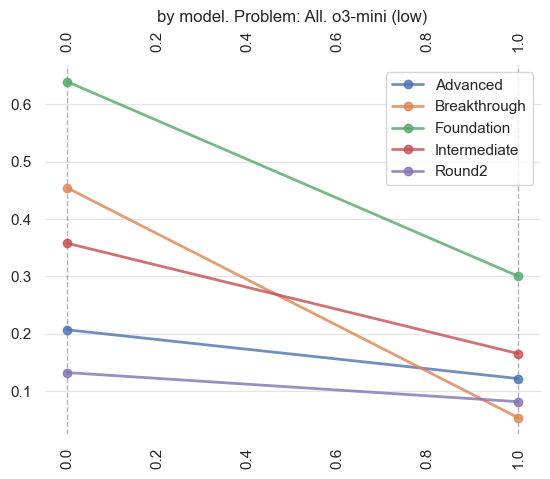

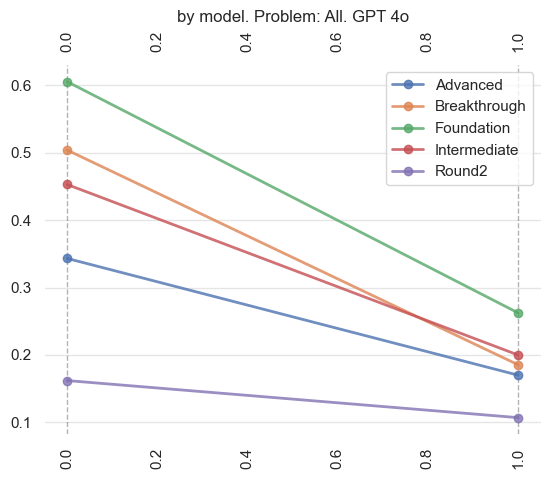

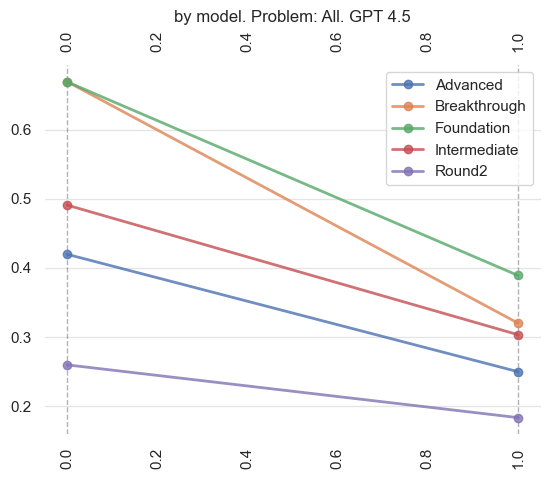

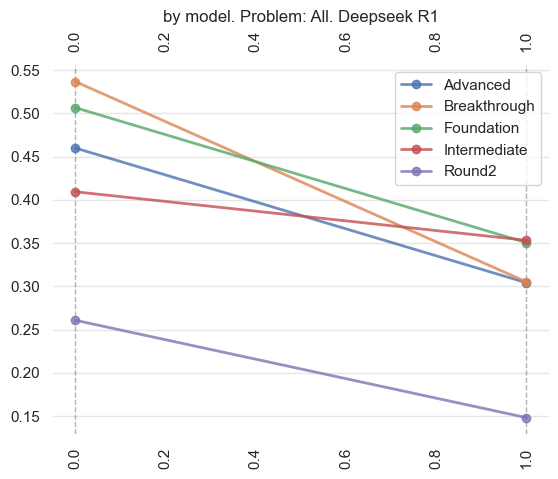

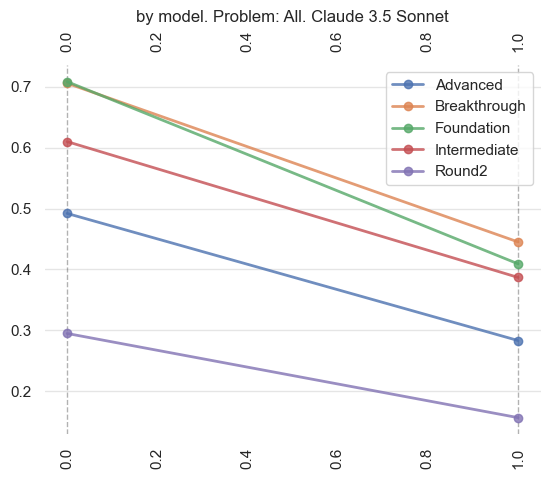

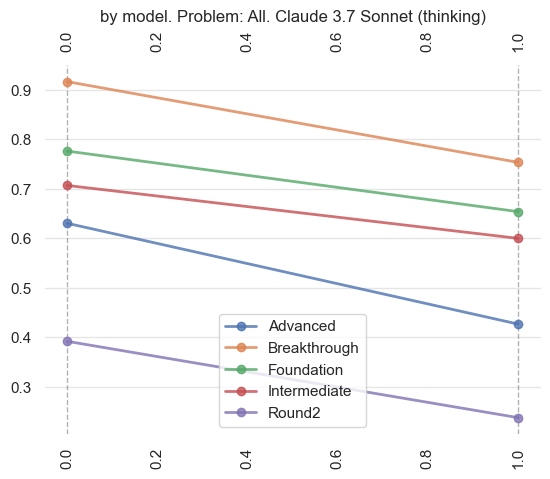

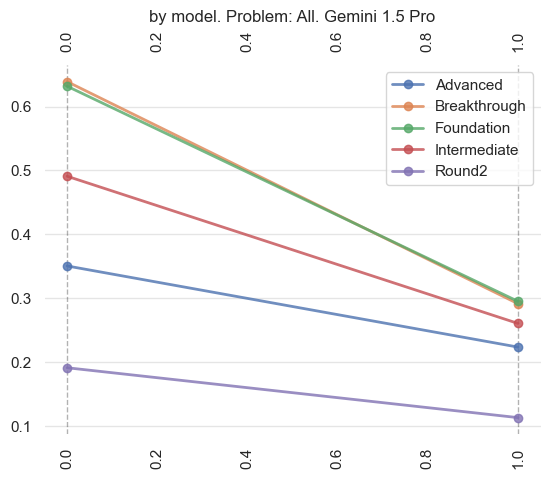

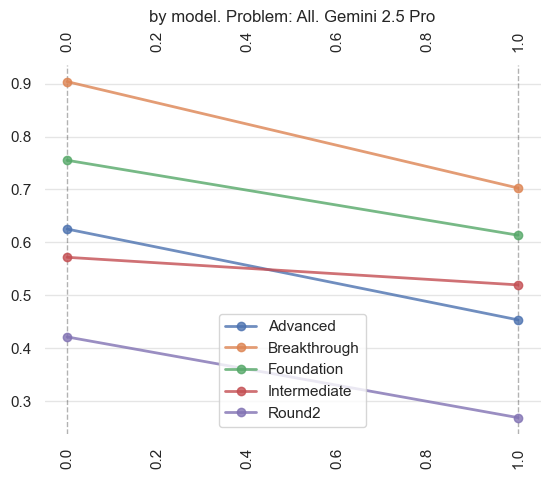

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


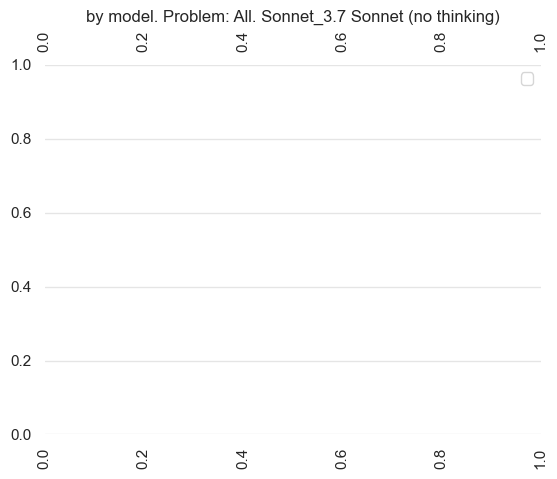

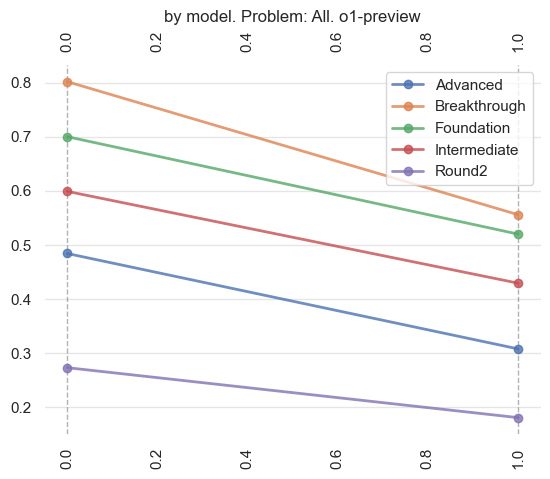

In [928]:
#Is the drop ? 
for m in all_models + ['o1-preview']:
    tmp = prob_metadata[(prob_metadata['model_name'] == m)].groupby(['Level and Score', 'obfuscated'])['exact_match_score'].mean().unstack()
    obfuscated_sorted = [True, False]
    trend_plot(tmp, out_suffix=m ) 
#trend_plot(prob_metadata[(prob_metadata['obfuscated']) & (prob_metadata['model_name'].isin(all_models + ['o1-preview']))], x_col="Level and Score", hue='model_name')


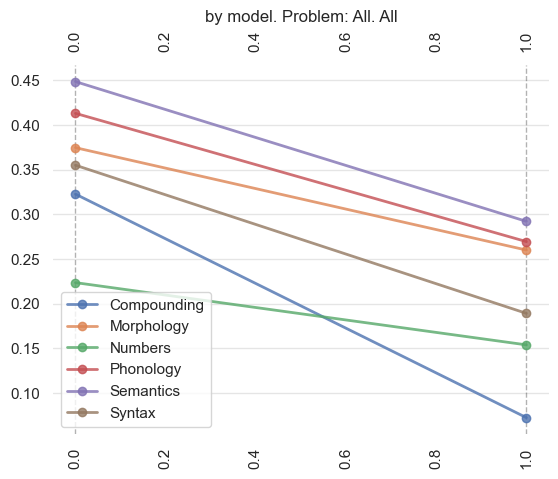

In [929]:
tmp = prob_metadata.groupby(['Subjects', 'obfuscated'])['exact_match_score'].mean().unstack()
obfuscated_sorted = [True, False]
trend_plot(tmp, out_suffix="All") 

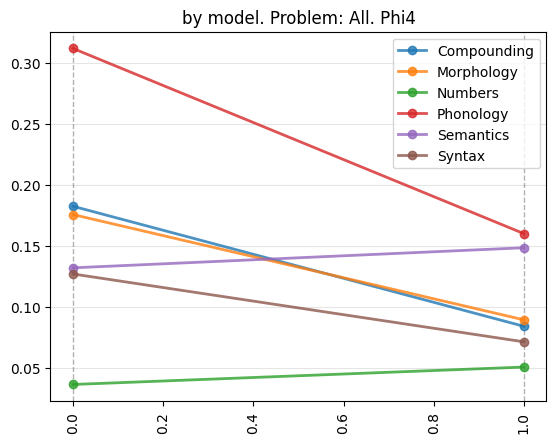

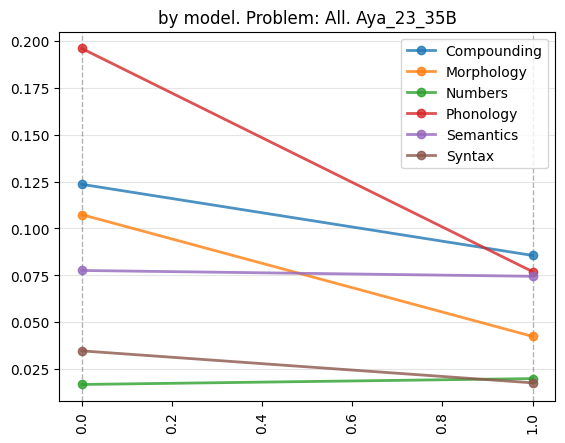

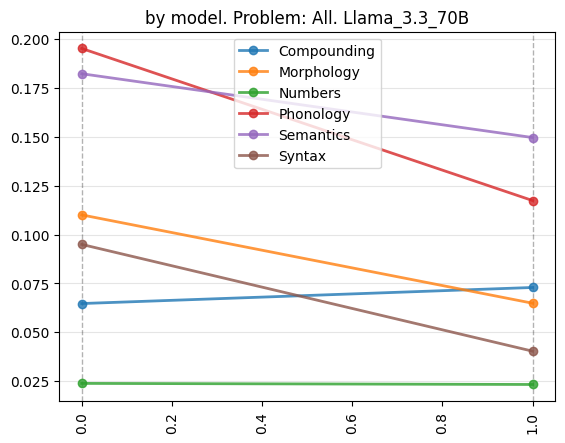

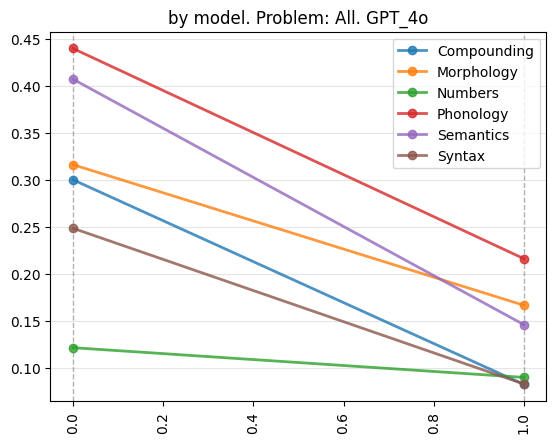

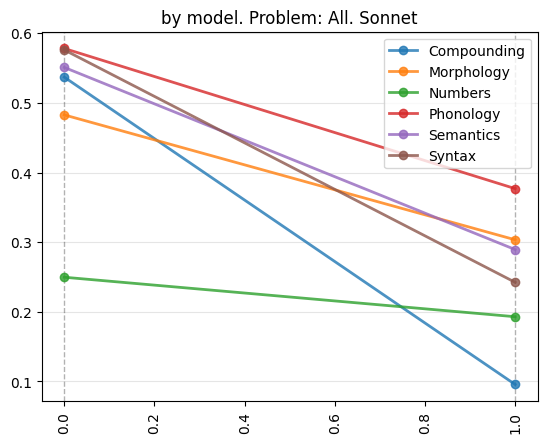

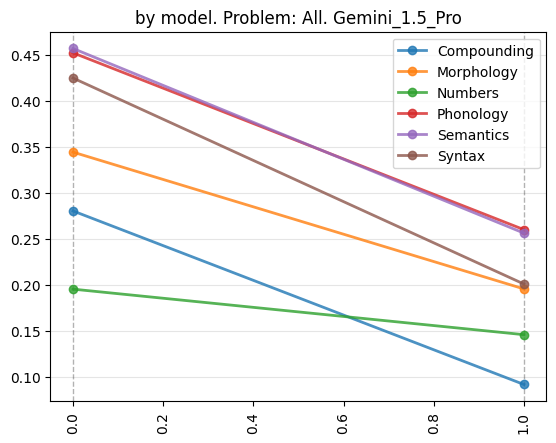

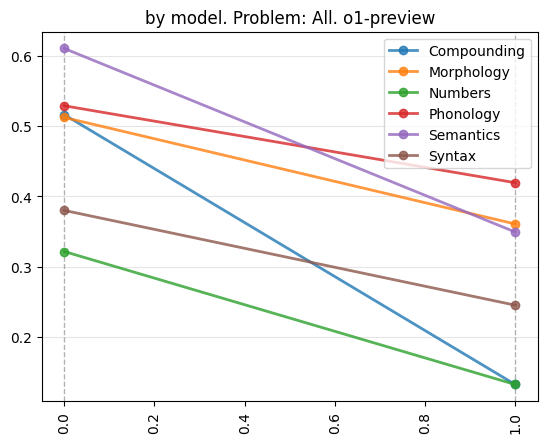

In [1449]:
#How's the drop by subjet?? 

for m in all_models + ['o1-preview']:
    tmp = prob_metadata[(prob_metadata['model_name'] == m)].groupby(['Subjects', 'obfuscated'])['exact_match_score'].mean().unstack()
    obfuscated_sorted = [True, False]
    trend_plot(tmp, out_suffix=m ) 
#trend_plot(prob_metadata[(prob_metadata['obfuscated']) & (prob_metadata['model_name'].isin(all_models + ['o1-preview']))], x_col="Level and Score", hue='model_name')


In [932]:
### Understand the problems with highest/ lowest reduction
highest_decrease = merged_means.sort_values(by=['exact_match_score_diff'])['overall_question_n'][:15].values
print(f"Highest drop: {highest_decrease}")
lowest_decrease = merged_means.sort_values(by=['exact_match_score_diff'])['overall_question_n'][-15:].values
print(f"Lowest drop: {lowest_decrease}")

Highest drop: [178 178 178 178 178 178 178 196 178 178 178 178 178 178 178]
Lowest drop: [135  92 135 148 147 160 160  16 160 160 160 160 160 160 160]


In [933]:
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches
import numpy as np, scipy.stats as st
import random



def plot_dist(subquestion_dfs, q_num, model_name, sample=None):

    #insp = subquestion_dfs[model_name].copy()
    insp = subquestion_dfs[subquestion_dfs['model_name'] == model_name].copy()
    if q_num:
        insp = insp[insp['overall_question_n'] == q_num]

    obf_sets = list(insp['obfuscated_question_n'].unique())
    
    if sample:
        
        #print(f"Before: {obf_sets}")
        obf_sets = random.sample(obf_sets, k=sample)
        obf_sets += [f"{q_num}_0000"]
        #print(f"After: {obf_sets}")
        
        insp = insp[insp['obfuscated_question_n'].isin(obf_sets)]
        #print(insp.shape)
        #insp = insp.sample(sample)
    else:
        sample = len(obf_sets)
    
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))
    axes = axes.flatten()
    
    colors = ['blue', 'green', 'purple', 'teal']

    res = {}
    
    for i, metric in enumerate(metrics.values()):
    
        ob_df = insp[insp['obfuscated']]
        og_df = insp[~insp['obfuscated']]
        
        og_score = og_df[metric].agg('mean')
        obf_score = ob_df[metric].agg('mean')

        og_score = np.nan_to_num(og_score)
        obf_score = np.nan_to_num(obf_score)
        #print(og_score, obf_score)
        
        
        #print(og_score)
        #print(obf_score)
        
        scores = ob_df.groupby(['obfuscated_question_n'])[metric].agg('mean').values
        scores = [np.nan_to_num(s) for s in scores]
        #print(scores)
        a = scores
        
        intervals = st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
        two_std = intervals[1] - intervals[0]
        #print(f"Conf Int. for {metric} - {intervals}")

        res[metric] = (obf_score, intervals)
        
        #subquestion_dfs[model_name].groupby(['obfuscated_question_n'])[list(metrics.values())].agg(['mean','std'])
        ax = axes[i]
        ax.hist(scores, bins=12, alpha=0.1, ec=f"{colors[i]}", lw=2, color=f"{colors[i]}") #'lightblue')
        # KDE
        
        kde = gaussian_kde(scores)
        min_s, max_s = min(scores), max(scores)
        x_range = np.linspace(min_s, max_s, 100)
        #print(insp.shape[0])

        ax2 = ax.twinx()
        ax2.plot(x_range, kde(x_range), color=colors[i], label=metric, alpha=0.8)
        ymin,ymax  = ax.get_ylim()

        ax.hlines(xmin=obf_score, xmax=og_score, y=[1], colors=['r'], ls='-', lw=14, alpha=0.2)
        
        ax.vlines(x=[og_score], ymin=ymin, ymax=ymax, colors=['tab:blue'], ls='--', lw=2, alpha=0.8)
        ax.vlines(x=[obf_score], ymin=ymin, ymax=ymax, colors=colors[i], ls='--', lw=2, alpha=0.8)
    
        #ax.set_title(metric)
        ax.set_xlabel(f"Metric: {metric}")
        ax.set_ylabel("Frequency")
        #ax.set_xlim(70, 95)  # Adjust x-axis limits as needed
        #ax.set_ylim(0, 2)  # Adjust y-axis limits as needed

    og_patch = mpatches.Patch(color='tab:blue', label='Non Obfuscated Mean', alpha=.8)
    obf_patch = mpatches.Patch(color=colors[i], label='Obfuscated Mean', alpha=.8)
    
    # Adjust layout
    plt.tight_layout()
    title=f'Distribution of metric values. Problem {q_num} - # Problem versions: {sample} - {model_name}'
    plt.suptitle(title, size=15, y=1.3)
    plt.legend(handles=[og_patch, obf_patch], loc='upper right', bbox_to_anchor=(1, 1.4))
    #fig.title("Distribution of all metric values for Problem sheet {q_num} - {model_name}", loc='center')
    plt.savefig(f'{title}.png', bbox_inches='tight')
    plt.show()
    return res

## Scores by difficulty

In [832]:
# Plot by difficulty

# Create custom colormap
import matplotlib
from matplotlib import colors, cm
from matplotlib.pyplot import subplots
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

plt.rcParams["font.family"] = 'sans-serif'

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


def heatmap_difficulty(data, all_models, metric, suffix="", prob_size=1, mask_below = -0.1, mask_above = 1, 
                  limit=None, c=newcmp, nolegend=False, ext='pdf', ylabel=r'$M_{obf}$'):
    
    def plt_img(df, all_levels, metric, ax):
        #gcols = ['overall_question_n', 'obfuscated_question_n_obf', ]
        diffs = []
        
        #metric = 'exact_match_score' #'rouge_score'
        for i, level in enumerate(all_levels):
            #print(mn)
            tmp = df[df['Level and Score'] == level].copy()
            #gcols = ['obfuscated_question_n_obf']
            means = tmp[metric].values

            
            #print(len(means))
            #means = tmp.groupby(['overall_question_n', 'question_n','subquestion','model_name'])[metric].mean().reset_index()
            #print(means)
            if means.shape[0] < 1:
                print(f"Skipping {level}")
                continue
            diffs.append(means)
            
        diffs = np.array(diffs)
        if diffs.ndim == 1:
            len_diff = len(diffs)
        else:
            len_diff = len(diffs[0])
        #print(len_diff)
            
    
        # create a single norm to be shared across all images
        norm = colors.Normalize(vmin=-1, vmax=1)
        
        
        #fig, ax = subplots(figsize=(40, 20))
        #ax.yt
        cmap = matplotlib.colormaps.get_cmap(c) #(rand_normal_y_norm)
        cmap.set_bad(color='green')
        img = ax.imshow(diffs, norm=norm, aspect=len_diff*1.5, cmap=cmap, interpolation='nearest')

        for i in range(diffs.shape[0]):
            for j in range(diffs.shape[1]):
                if diffs[i, j] < .6:
                    tcolor = "black"
                else:
                    tcolor = "white"
                    
                text = ax.text(j, i, f"{diffs[i, j]:.2f}", ha="center", va="center", color=tcolor, rotation=90, size=24)
        
        return img, norm, cmap

    
    all_levels = ['Breakthrough','Foundation', 'Intermediate', 'Advanced', 'Round2']


    gridspec = {'width_ratios': [1 for _ in  range(len(all_models))] + [0.4]}
    #print(f"{len(problems)} problems will be included")
    fig, axes = subplots(1, len(all_models) + 1, figsize=(35, 8), gridspec_kw=gridspec)


    for i, model in enumerate(all_models):
        #print(model)
        subset = data[data['model_name'] == model].copy()
        #print(subset.shape)
        img, norm, cmap = plt_img(subset, all_levels, metric, axes[i])
        axes[i].set_title(f"{model}", rotation=90, fontsize=30)
        axes[i].set_yticks([],[])
        axes[i].set_xticks([],[])

    #plt.ylabel(all_models)
    axes[0].set_yticks(list(range(len(all_levels))), [f"{m}  " for m in all_levels], fontsize=30)

    # Set legend over fake axis
    axes[-1].spines['top'].set_visible(True)
    axes[-1].spines['right'].set_visible(True)
    axes[-1].spines['bottom'].set_visible(True)
    axes[-1].spines['left'].set_visible(True)
    axes[-1].set_yticks([],[])
    axes[-1].set_xticks([],[])
    
    if not nolegend:
        cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=c), ax=axes[-1], fraction=.99, pad=.9)
        cbar.ax.tick_params(labelsize=30) 
        cbar.ax.set_ylabel(ylabel, fontsize=30)

    #axes[1].update_traces.xgap(1)
    title = f"Problem Number"
    #plt.title(title, loc='center')
    
    plt.savefig(f'../data/img/heatmap{suffix}.{ext}', bbox_inches='tight')
    plt.show()


In [679]:
#bar_plot(prob_metadata[prob_metadata['model_name'].isin(model_order)], ['exact_match_score'], hue = 'Level and Score', x_col='model_name', order=model_order,   ext='png')

In [825]:
# Scores by difficulty
scores_by_level = prob_metadata[(prob_metadata['model_name'].isin(model_order)) & (prob_metadata['obfuscated'])].groupby(['model_name','Level and Score'])['exact_match_score'].mean().reset_index()
#scores_by_level

model_name Level and Score  exact_match_score
0               Aya 23 35B        Advanced           0.080868
1               Aya 23 35B    Breakthrough           0.005529
2               Aya 23 35B      Foundation           0.057726
3               Aya 23 35B    Intermediate           0.048402
4               Aya 23 35B          Round2           0.046586
5        Claude 3.5 Sonnet        Advanced           0.283488
6        Claude 3.5 Sonnet    Breakthrough           0.445262
7        Claude 3.5 Sonnet      Foundation           0.409338
8        Claude 3.5 Sonnet    Intermediate           0.387018
9        Claude 3.5 Sonnet          Round2           0.156944
10             Deepseek R1        Advanced           0.304272
11             Deepseek R1    Breakthrough           0.305248
12             Deepseek R1      Foundation           0.350583
13             Deepseek R1    Intermediate           0.353348
14             Deepseek R1          Round2           0.148313
15                 GPT 4.5        Advanced           0.249707
16                 GPT 4.5    Breakthrough           0.320032
17                 GPT 4.5      Foundation           0.388926
18                 GPT 4.5    Intermediate           0.303232
19                 GPT 4.5          Round2           0.183240
20                  GPT 4o        Advanced           0.164369
21                  GPT 4o    Breakthrough           0.166166
22                  GPT 4o      Foundation           0.207155
23                  GPT 4o    Intermediate           0.188630
24                  GPT 4o          Round2           0.115451
25          Gemini 1.5 Pro        Advanced           0.223839
26          Gemini 1.5 Pro    Breakthrough           0.291627
27          Gemini 1.5 Pro      Foundation           0.295337
28          Gemini 1.5 Pro    Intermediate           0.260816
29          Gemini 1.5 Pro          Round2           0.113551
30          Gemini 2.5 Pro        Advanced           0.453576
31          Gemini 2.5 Pro    Breakthrough           0.702754
32          Gemini 2.5 Pro      Foundation           0.613591
33          Gemini 2.5 Pro    Intermediate           0.519682
34          Gemini 2.5 Pro          Round2           0.268773
35  Llama 3.3 70B-Instruct        Advanced           0.094272
36  Llama 3.3 70B-Instruct    Breakthrough           0.041136
37  Llama 3.3 70B-Instruct      Foundation           0.164162
38  Llama 3.3 70B-Instruct    Intermediate           0.101331
39  Llama 3.3 70B-Instruct          Round2           0.044089
40                    Phi4        Advanced           0.118669
41                    Phi4    Breakthrough           0.073998
42                    Phi4      Foundation           0.211235
43                    Phi4    Intermediate           0.106889
44                    Phi4          Round2           0.079522
45              o1-preview        Advanced           0.307828
46              o1-preview    Breakthrough           0.556080
47              o1-preview      Foundation           0.520126
48              o1-preview    Intermediate           0.429397
49              o1-preview          Round2           0.180654
50          o3-mini (high)        Advanced           0.308269
51          o3-mini (high)    Breakthrough           0.512460
52          o3-mini (high)      Foundation           0.513108
53          o3-mini (high)    Intermediate           0.390834
54          o3-mini (high)          Round2           0.160379
55           o3-mini (low)        Advanced           0.121707
56           o3-mini (low)    Breakthrough           0.053516
57           o3-mini (low)      Foundation           0.300508
58           o3-mini (low)    Intermediate           0.165256
59           o3-mini (low)          Round2           0.081369

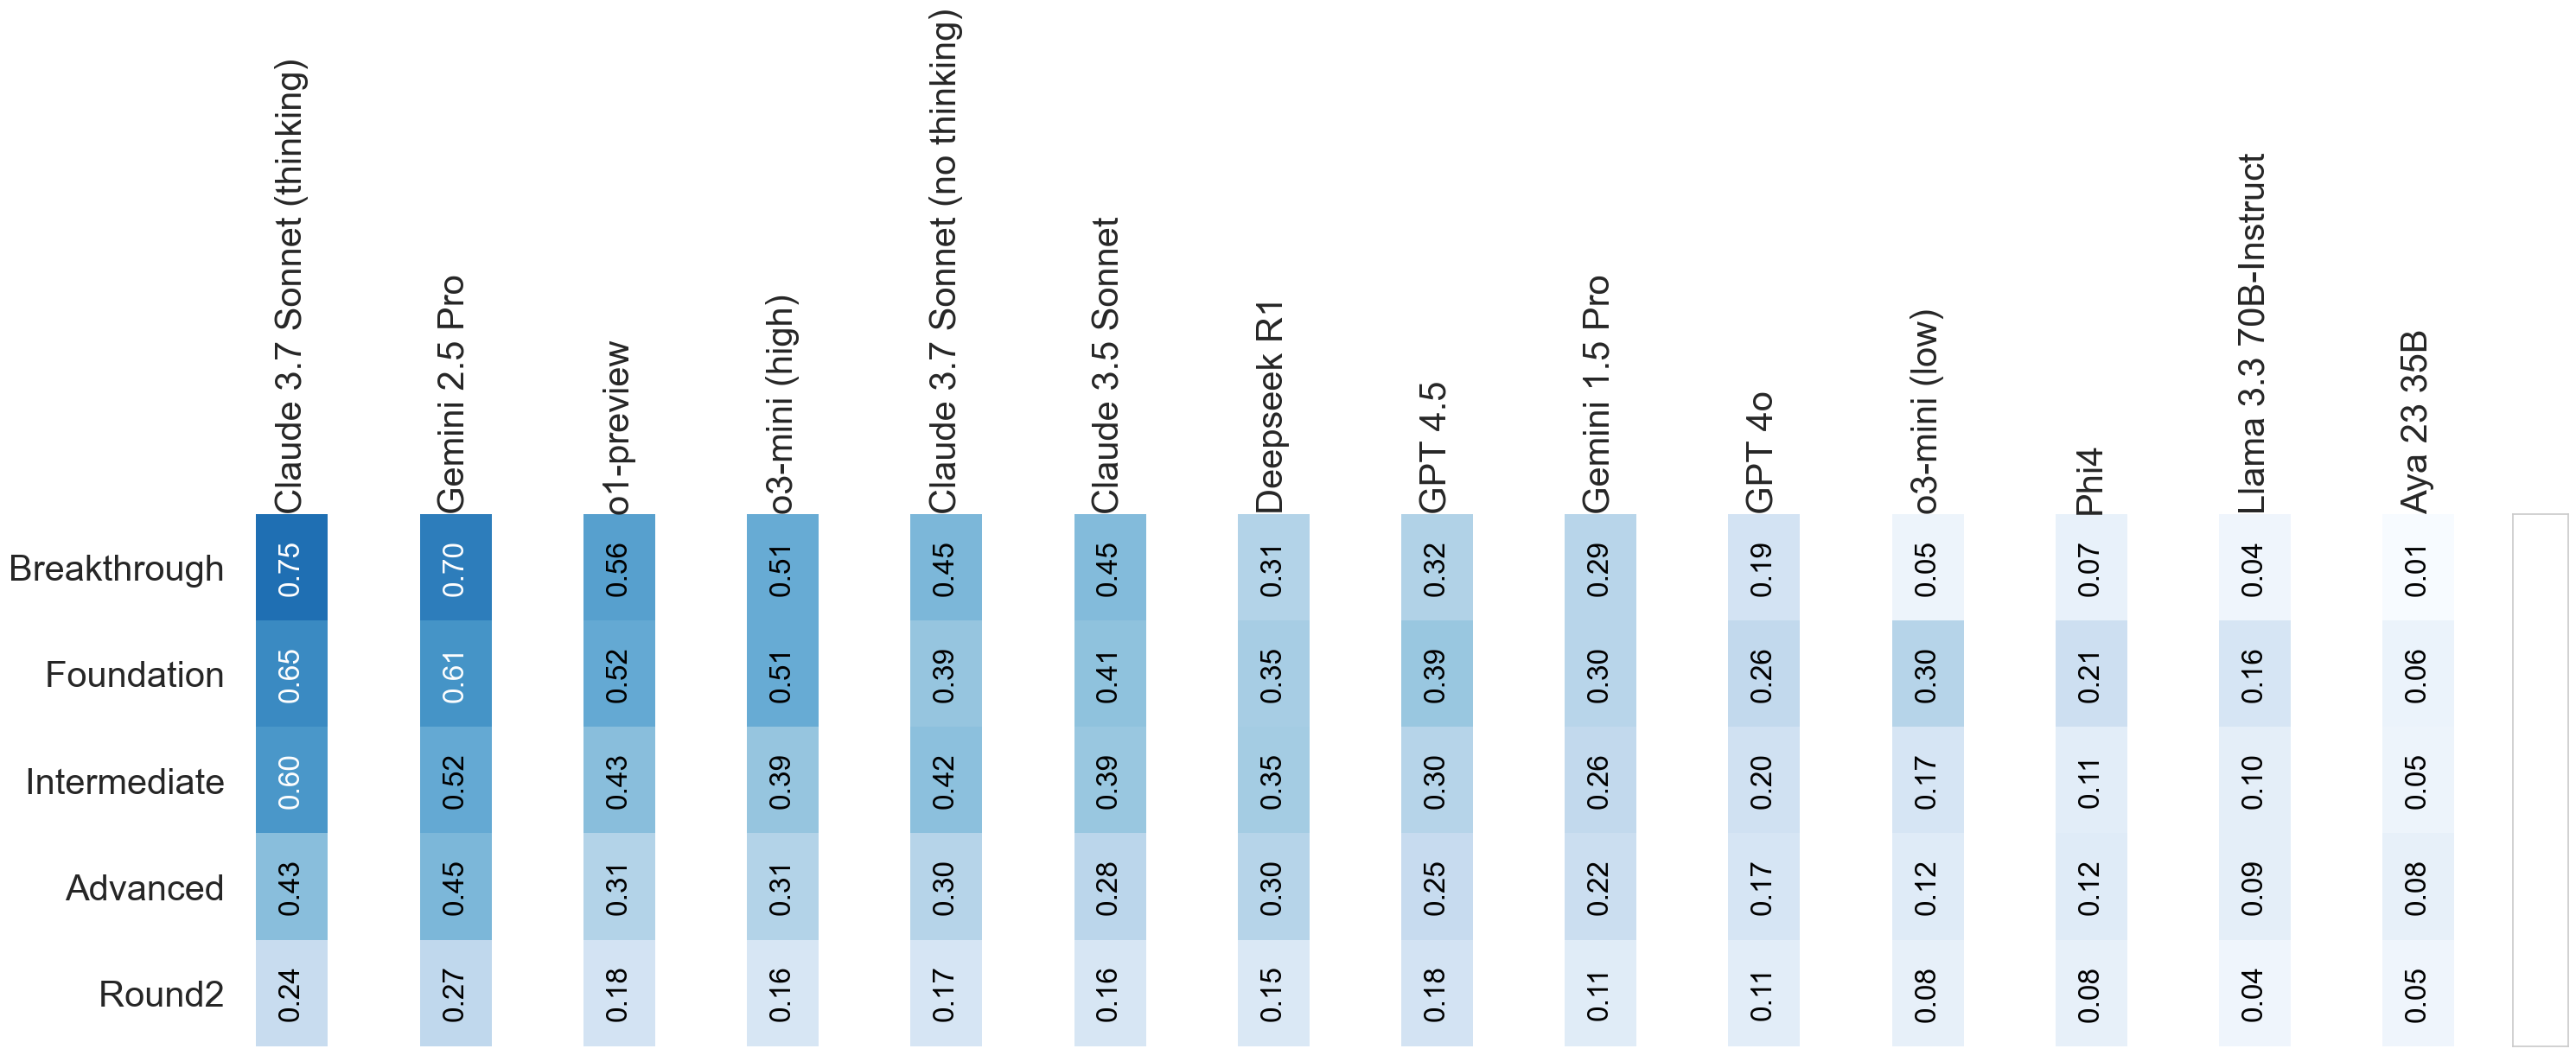

In [833]:
heatmap_difficulty(scores_by_level, model_order, 'exact_match_score', suffix="by_difficulty", nolegend=True, ext='svg')

o1-preview
4
0
3
2
1
o3-mini (high)
4
0
3
1
2
Claude 3.7 Sonnet
4
0
3
2
1
GPT 4.5
4
0
3
1
2
Claude 3.5 Sonnet
4
0
3
2
1


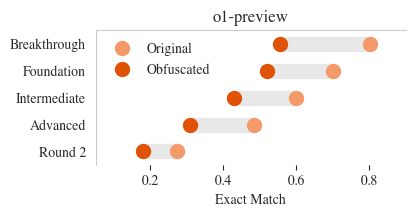

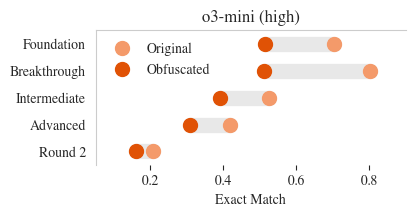

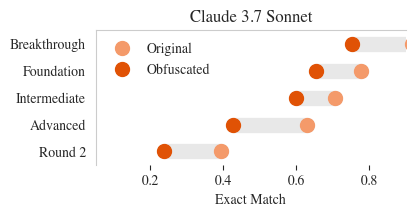

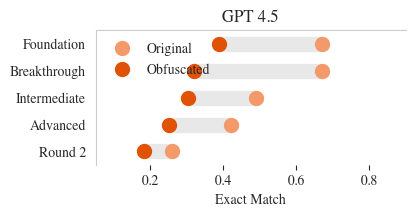

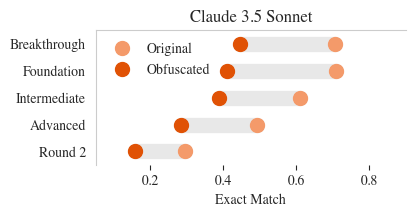

In [257]:
# Harry's plot

good_models = ['o1-preview', 'o3-mini (high)', 'Claude 3.7 Sonnet', 'GPT 4.5', 'Claude 3.5 Sonnet']

for model in good_models:
    print(model)
    tmp = prob_metadata[prob_metadata['model_name'].isin([model])].groupby(['Level and Score', 'obfuscated'])['exact_match_score'].mean().unstack()
    obfuscated_sorted = [True, False]
    tmp = tmp.reset_index()
    tmp.iloc[4, 0] = "Round 2"
    tmp['diff'] = tmp[True]-tmp[False]
    categories = tmp['Level and Score']
    tmp = tmp.sort_values(True)
    # name the plot
    fig, ax = plt.subplots(figsize=(4, 1.75))
    for i, row in tmp.iterrows():
        print(i)
        # x-values for “False” vs “True”
        x_false = row[False]
        x_true  = row[True]
        #Plot the “bridge” line horizontally
        ax.plot([x_false, x_true],
                [row['Level and Score'], row['Level and Score']],
                color='lightgray', linestyle='-', lw=11, alpha=0.5)
        # Scatter the two points
        ax.scatter(x_false, row['Level and Score'], color='#F49A6A', s=100, zorder=2)
        ax.scatter(x_true,  row['Level and Score'], color='#E05205', s=100, zorder=2)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(True)
    plt.rcParams["font.family"] = 'Times'
    import matplotlib.lines as mlines
    blue_dot = mlines.Line2D([], [], color='#F49A6A', marker='o', linestyle='None', markersize=10, label='Original')#, facecolors='white')
    red_dot = mlines.Line2D([], [], color='#E05205', marker='o', linestyle='None', markersize=10, label='Obfuscated')#,facecolors='white')
    # Add legend with only these two items
    ax.legend(handles=[blue_dot, red_dot], loc='upper left', fontsize=10, frameon=False)
    ax.set_ylim(-0.5, len(categories) - 0.5)
    ax.set_xlim(0.05, 0.90)
    ax.set_title(model)
    ax.set_xlabel('Exact Match')
    ax.xaxis.set_ticks_position('bottom')
    #plt.savefig(f"{model}.pdf", bbox_inches='tight')


## Scores in relation to language resourcedness

======= Open Models / exact_match_score ======= 
                            OLS Regression Results                            
Dep. Variable:      exact_match_score   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     7.801
Date:                Mon, 12 May 2025   Prob (F-statistic):            0.00554
Time:                        19:41:44   Log-Likelihood:                -12.296
No. Observations:                 316   AIC:                             28.59
Df Residuals:                     314   BIC:                             36.10
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1 

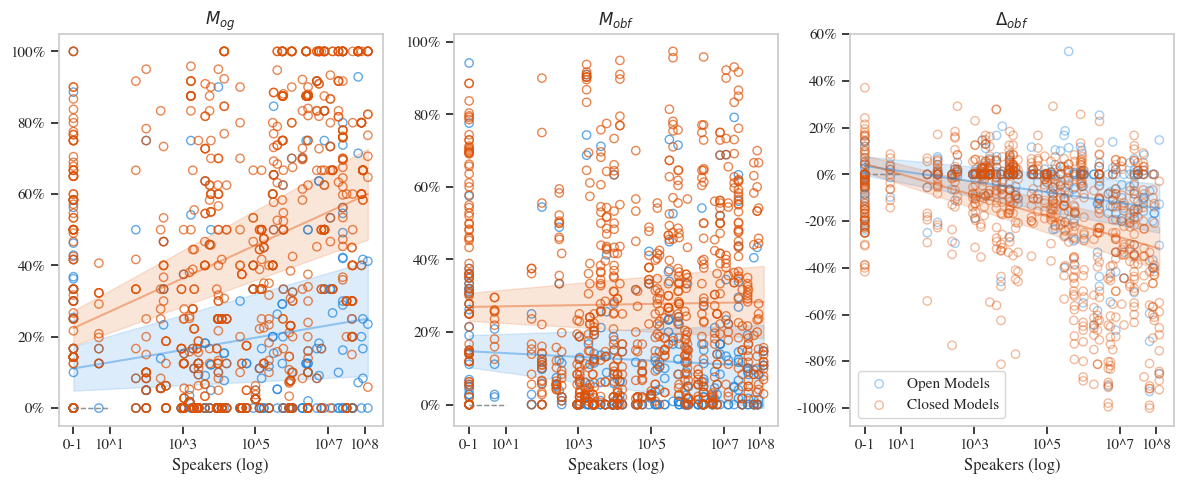

In [946]:
# Plot obfuscated scores

plt.rcParams["font.family"] = 'Times'
m2 = f"{m}_obf"

from cmcrameri import (
    cm,
) 
import statsmodels.api as sm
from matplotlib import ticker


fig, axs = plt.subplots(1, 3, figsize=(12, 5))

m = "exact_match_score"
j = 0

labels = ['Open Models', 'Closed Models', 'O1-preview']

colors = ['#1C83DE', '#E05205'] # [cm.hawaii(.1), cm.hawaii(.5), cm.hawaii(.9)] 


predictor = "log10_Speakers" #'Digital Support'

for i, selected in enumerate([open_models, closed_models]):
    print(f"======= {labels[i]} / {m} ======= ")
    tmp_og = prob_metadata[(prob_metadata['model_name'].isin(selected)) & (~prob_metadata['obfuscated'])]
    tmp_og = (tmp_og.groupby(["Language", "model_name"])[["exact_match_score", predictor]]
        .mean()
        .reset_index())
    
    axs[j].scatter(
        data=tmp_og,
        y=m,
        x=predictor,
        label=labels[i] ,
        color=colors[i],
        facecolors='none', 
        marker='o',
        alpha=.7,
    )

    # fit least-squares
    data = np.array(tmp_og[predictor].values).reshape([-1, 1])

    lm = sm.OLS(
        tmp_og[m], np.hstack((data, np.ones((len(data), 1))))
    )
    res = lm.fit()
    w = res.params
    print(res.summary())

    xx = np.linspace(data.min(), data.max()).T
    axs[j].plot(xx, w[0] * xx + w[1], color=colors[i], alpha=.4)
    axs[j].hlines(xmin=0, xmax=1, y=[0], colors=['gray'], ls='--', lw=1, alpha=0.6)

    ci = res.conf_int()
    axs[j].fill_between(
        xx,
        ci[0][0] * xx + ci[0][1],
        ci[1][0] * xx + ci[1][1],
        color=colors[i],
        alpha=0.15,
    )

    #axs[j].legend(loc="upper right", frameon=True)
    axs[j].set_xticks(
        [0, 1, 3, 5, 7, 8], labels=["0-1", "10^1", "10^3", "10^5", "10^7", "10^8"]
    )
    axs[j].spines['top'].set_visible(True)
    axs[j].spines['right'].set_visible(True)
    axs[j].spines['bottom'].set_visible(True)
    axs[j].spines['left'].set_visible(True)
    
    axs[j].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:0.0%}"))
    axs[j].set_xlabel("Speakers (log)")
    #axs[j].set_ylabel(m)
    axs[j].set_title("$M_{og}$")
    axs[j].xaxis.set_ticks_position('bottom')
    axs[j].yaxis.set_ticks_position('left')



#selected = open_models #['o1'] # closed_models

m2 = "exact_match_score_obf"
j = 1


for i, selected in enumerate([open_models, closed_models]):
    print(f"======= {labels[i]}  / {m2} ======= ")
    tmp_obf = merge_means_metadata[merge_means_metadata['model_name'].isin(selected)]
    tmp_obf = (tmp_obf.groupby(["Language", "model_name"])[["exact_match_score_og", "exact_match_score_diff", "exact_match_score_obf", predictor]]
            .mean()
            .reset_index())
    
    axs[j].scatter(
        data=tmp_obf,
        y=m2,
        x=predictor,
        label=labels[i] ,
        color=colors[i],
        facecolors='none', 
        marker='o',
        alpha=.7,
    )

    # fit least-squares
    data = np.array(tmp_obf[predictor].values).reshape([-1, 1])

    lm = sm.OLS(
        tmp_obf[m2], np.hstack((data, np.ones((len(data), 1))))
    )
    res = lm.fit()
    print(res.summary())
    w = res.params

    xx = np.linspace(data.min(), data.max()).T
    axs[j].plot(xx, w[0] * xx + w[1], color=colors[i], alpha=.4)
    axs[j].hlines(xmin=0, xmax=1, y=[0], colors=['gray'], ls='--', lw=1, alpha=0.6)

    ci = res.conf_int()
    axs[j].fill_between(
        xx,
        ci[0][0] * xx + ci[0][1],
        ci[1][0] * xx + ci[1][1],
        color=colors[i],
        alpha=0.15,
    )

    #axs[j].legend(loc="upper right", frameon=True)
    axs[j].set_xticks(
        [0, 1, 3, 5, 7, 8], labels=["0-1", "10^1", "10^3", "10^5", "10^7", "10^8"]
    )
    axs[j].spines['top'].set_visible(True)
    axs[j].spines['right'].set_visible(True)
    axs[j].spines['bottom'].set_visible(True)
    axs[j].spines['left'].set_visible(True)
    axs[j].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:0.0%}"))
    axs[j].set_xlabel("Speakers (log)")
    axs[j].set_title("$M_{obf}$")
    axs[j].xaxis.set_ticks_position('bottom')
    axs[j].yaxis.set_ticks_position('left')

m3 = "exact_match_score_diff"
j= 2

for i, selected in enumerate([open_models, closed_models]):
    print(f"======= {labels[i]} / {m3} ======= ")

    tmp_obf = merge_means_metadata[merge_means_metadata['model_name'].isin(selected)]
    tmp_obf = (tmp_obf.groupby(["Language", "model_name"])[["exact_match_score_og", "exact_match_score_diff", "exact_match_score_obf", predictor]]
            .mean()
            .reset_index())
    
    axs[j].scatter(
        data=tmp_obf,
        y=m3,
        x=predictor,
        label=labels[i] ,
        color=colors[i],
        facecolors='none', 
        marker='o',
        alpha=.4,
    )

    # fit least-squares
    data = np.array(tmp_obf[predictor].values).reshape([-1, 1])

    lm = sm.OLS(
        tmp_obf[m3], np.hstack((data, np.ones((len(data), 1))))
    )
    res = lm.fit()
    print(res.summary())
    w = res.params

    xx = np.linspace(data.min(), data.max()).T
    axs[j].plot(xx, w[0] * xx + w[1], color=colors[i], alpha=.4)
    axs[j].hlines(xmin=0, xmax=1, y=[0], colors=['gray'], ls='--', lw=1, alpha=0.6)

    ci = res.conf_int()
    axs[j].fill_between(
        xx,
        ci[0][0] * xx + ci[0][1],
        ci[1][0] * xx + ci[1][1],
        color=colors[i],
        alpha=0.15,
    )

    axs[j].legend(loc="lower left", frameon=True)
    axs[j].set_xticks(
        [0, 1, 3, 5, 7, 8], labels=["0-1", "10^1", "10^3", "10^5", "10^7", "10^8"]
    )
    axs[j].spines['top'].set_visible(True)
    axs[j].spines['right'].set_visible(True)
    axs[j].spines['bottom'].set_visible(True)
    axs[j].spines['left'].set_visible(True)
    axs[j].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:0.0%}"))
    axs[j].set_xlabel("Speakers (log)")
    axs[j].set_title(latex_s)
    axs[j].xaxis.set_ticks_position('bottom')
    axs[j].yaxis.set_ticks_position('left')



fig.tight_layout() 
plt.savefig(f'../data/img/regression.svg', bbox_inches='tight')
plt.show()


======= Open Models /  Breakthrough ======= 
                              OLS Regression Results                              
Dep. Variable:     exact_match_score_diff   R-squared:                       0.102
Model:                                OLS   Adj. R-squared:                  0.062
Method:                     Least Squares   F-statistic:                     2.508
Date:                    Tue, 06 May 2025   Prob (F-statistic):              0.128
Time:                            17:13:17   Log-Likelihood:                 4.7796
No. Observations:                      24   AIC:                            -5.559
Df Residuals:                          22   BIC:                            -3.203
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

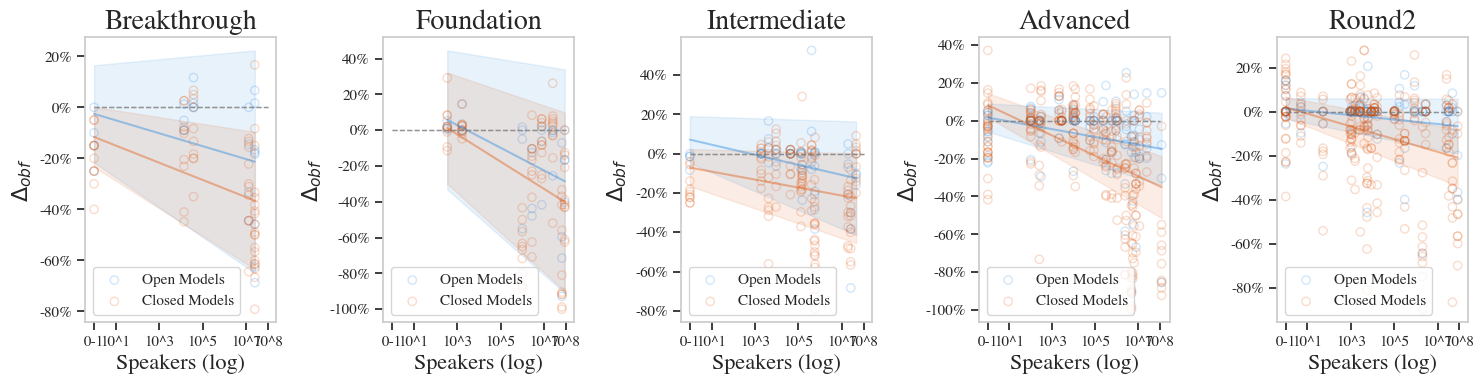

In [777]:
# Plot by difficulty

plt.rcParams["font.family"] = 'Times'
plt.rcParams['axes.grid'] = False

from cmcrameri import (
    cm,
) 
import statsmodels.api as sm
from matplotlib import ticker


levels = ['Breakthrough', 'Foundation', 'Intermediate', 'Advanced', 'Round2',]

labels = ['Open Models', 'Closed Models', 'O1-preview']

colors = ['#1C83DE', '#E05205'] # [cm.hawaii(.1), cm.hawaii(.5), cm.hawaii(.9)] 


predictor = "log10_Speakers" #'Digital Support'

m3 = "exact_match_score_diff"


fig, axs = plt.subplots(1, len(levels), figsize=(15, 4))

for j, level in enumerate(levels):

    for i, selected in enumerate([open_models, closed_models]):
        print(f"======= {labels[i]} /  {level} ======= ")
    
        tmp_obf = merge_means_metadata[(merge_means_metadata['model_name'].isin(selected)) & (merge_means_metadata['Level and Score'] == level)]
        tmp_obf = (tmp_obf.groupby(["Language", "model_name"])[["exact_match_score_og", "exact_match_score_diff", "exact_match_score_obf", predictor]]
                .mean()
                .reset_index())
        
        axs[j].scatter(
            data=tmp_obf,
            y=m3,
            x=predictor,
            label=labels[i] ,
            color=colors[i],
            facecolors='none', 
            marker='o',
            alpha=.2,
        )
    
        # fit least-squares
        data = np.array(tmp_obf[predictor].values).reshape([-1, 1])
    
        lm = sm.OLS(
            tmp_obf[m3], np.hstack((data, np.ones((len(data), 1))))
        )
        res = lm.fit()
        print(res.summary())
        w = res.params
    
        xx = np.linspace(data.min(), data.max()).T
        axs[j].plot(xx, w[0] * xx + w[1], color=colors[i], alpha=.4)
        axs[j].hlines(xmin=0, xmax=8, y=[0], colors=['gray'], ls='--', lw=1, alpha=0.6)
    
        ci = res.conf_int()
        axs[j].fill_between(
            xx,
            ci[0][0] * xx + ci[0][1],
            ci[1][0] * xx + ci[1][1],
            color=colors[i],
            alpha=0.1,
        )
    
        axs[j].legend(loc="lower left", frameon=True)
        axs[j].set_xticks(
            [0, 1, 3, 5, 7, 8], labels=["0-1", "10^1", "10^3", "10^5", "10^7", "10^8"]
        )
        axs[j].spines['top'].set_visible(True)
        axs[j].spines['right'].set_visible(True)
        axs[j].spines['bottom'].set_visible(True)
        axs[j].spines['left'].set_visible(True)
        axs[j].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:0.0%}"))
        axs[j].set_xlabel("Speakers (log)", fontsize=16)
        axs[j].set_ylabel(latex_s, fontsize=16)
        axs[j].set_title(level, fontsize=20)
        axs[j].xaxis.set_ticks_position('bottom')
        axs[j].yaxis.set_ticks_position('left')


fig.tight_layout() 
plt.savefig(f'../data/img/regression_by_difficulty.pdf', bbox_inches='tight')
plt.show()

## Finetuning results

In [386]:
# get difference

baseline_models = ['Llama 3.2 3B Inst', 'Llama 3.2 1B Inst']
finetuned_models = ['Ours 1B', 'Ours 3B', 'Ours 1B (Adv)']
model_class = {'Llama 3.2 1B Inst': '1B', 
               'Llama 3.2 3B Inst' : '3B',
               'Ours 1B': '1B',
               'Ours 3B': '3B'}


untrained = subquestion_dfs[subquestion_dfs['model_name'].isin(baseline_models)]
trained = subquestion_dfs[subquestion_dfs['model_name'].isin(finetuned_models)]

untrained['model_class'] = untrained['model_name'].map(lambda x: model_class[x])
trained['model_class'] = trained['model_name'].map(lambda x: model_class[x])

# merge 
merge_cols = ['overall_question_n', 'obfuscated_question_n','question_n','subquestion', 'model_class']
train_df = untrained.merge(trained, on=merge_cols, suffixes=['_og', '_ft'], validate='one_to_many')
train_df['split'] = train_df['split_key_ft'].map(lambda x: split_mappings[x])

# merge with question changes
merge_cols = ['overall_question_n', 'obfuscated_question_n','question_n','subquestion']
questions_changed_index_cols = ['overall_question_n',	'obfuscated_question_n_obf',	'question_n',	'subquestion']
questions_changed_index = merged.groupby(['overall_question_n', 'obfuscated_question_n_obf', 'question_n','subquestion','answer_obf_changed'])['model_name'].count().reset_index()


train_df = train_df.merge(questions_changed_index, left_on=merge_cols, right_on=questions_changed_index_cols, suffixes=['', '_metadata'], validate='many_to_one')
print(train_df.shape)

for metric, m in metrics.items():
    train_df[f"{m}_ftdiff"] = train_df[f"{m}_ft"] - train_df[f"{m}_og"]
    train_df[f"{m}_worse"] = train_df[f"{m}_ftdiff"] < 0
    train_df[f"{m}_og_pos"] = train_df[f"{m}_og"] > 0
    print(m)

metric_cols = []
for metric, m in metrics.items():
    metric_cols.append(f"{m}_og")
    metric_cols.append(f"{m}_ft")
    metric_cols.append(f"{m}_ftdiff")
    metric_cols.append(f"{m}_worse")
    metric_cols.append(f"{m}_og_pos")



(26455, 39)
bleu_score
chrf_score
exact_match_score


In [387]:
train_df.shape

(26455, 48)

In [388]:
train_df.groupby('split').size()

split
dev                                1527
questions & obfuscations           1798
train                              6190
unseen obfuscations                2168
unseen problems                    5674
unseen questions                   8048
unseen questions & obfuscations    1050
dtype: int64

In [389]:
train_df.groupby(['model_name_ft','split',])['exact_match_score_ftdiff'].mean().unstack().reset_index()[['model_name_ft', 'train',	'dev',	'unseen obfuscations','unseen questions & obfuscations',	'unseen problems',	'unseen questions']]


split model_name_ft     train       dev  unseen obfuscations  \
0           Ours 1B  0.400000       NaN                  NaN   
1           Ours 3B  0.712634  0.007204             0.684041   

split  unseen questions & obfuscations  unseen problems  unseen questions  
0                                  NaN              NaN               NaN  
1                             0.024762         0.007402          0.019508

In [195]:
# Print latext for finetuning results in total

print(train_df.groupby(['model_name_ft','split',])['exact_match_score_ftdiff'].mean().unstack().reset_index()[['model_name_ft', 'train',	'dev',	'unseen obfuscations',	'unseen questions & obfuscations', 'unseen problems',	'unseen questions']].to_latex(index=False, 
                                                                                                                          escape=True, 
                                                                                                                          formatters={"dev": "{:.2f}", 'train':"{:+.2f}", 
                                                                                                                                      'unseen questions' : "{:+.2f}",
                                                                                                                                      'unseen obfuscations':"{:+.2f}",
                                                                                                                                      'unseen problems': "{:+.2f}"}))

\begin{tabular}{lrrrrr}
\toprule
model\_name\_ft & train & dev & unseen obfuscations & unseen problems & unseen questions \\
\midrule
Ours 1B & +0.58 & 0.02 & +0.56 & +0.02 & +0.03 \\
Ours 3B & +0.71 & 0.01 & +0.68 & +0.01 & +0.02 \\
\bottomrule
\end{tabular}



In [130]:
train_df.columns

Index(['split_key_og', 'obfuscated_question_n', 'question_n', 'model_name_og',
       'overall_question_n', 'obfuscated_og', 'question_og', 'subquestion',
       'correct_answer_og', 'model_answer_og', 'model_answers_og_og',
       'model_raw_response_og', 'model_answers_extracted_og',
       'exact_match_score_og', 'bleu_score_og', 'chrf_score_og', 'ans_len_og',
       'ans_type_og', 'model_class', 'split_key_ft', 'model_name_ft',
       'obfuscated_ft', 'question_ft', 'correct_answer_ft', 'model_answer_ft',
       'model_answers_og_ft', 'model_raw_response_ft',
       'model_answers_extracted_ft', 'exact_match_score_ft', 'bleu_score_ft',
       'chrf_score_ft', 'ans_len_ft', 'ans_type_ft', 'split'],
      dtype='object')

In [179]:
cols = ['model_name_ft', 'answer_obf_changed']  + ['train',	'dev',	'unseen obfuscations',	'unseen questions & obfuscations',  'unseen problems',	'unseen questions']
train_df.groupby(['model_name_ft', 'obfuscated_ft', 'answer_obf_changed', 'split',])['exact_match_score_ftdiff'].mean().unstack().reset_index()[cols]

split model_name_ft  answer_obf_changed     train       dev  \
0           Ours 1B               False  0.894737       NaN   
1           Ours 1B                True  0.206186       NaN   
2           Ours 3B               False  0.891529  0.010467   
3           Ours 3B                True  0.454399 -0.007018   

split  unseen obfuscations  unseen questions & obfuscations  unseen problems  \
0                      NaN                              NaN              NaN   
1                      NaN                              NaN              NaN   
2                 0.902920                         0.033426        -0.010855   
3                 0.376249                         0.020260         0.019875   

split  unseen questions  
0                   NaN  
1                   NaN  
2              0.022626  
3              0.017937

In [141]:
# Print latext for finetuning results by answer changing
train_df.groupby(['model_name_ft', 'answer_obf_changed', 'split',])['exact_match_score_ftdiff'].mean().unstack()
cols = ['model_name_ft', 'answer_obf_changed']  + ['train',	'dev',	'unseen obfuscations',	'unseen problems',	'unseen questions']


l = train_df.groupby(['model_name_ft', 'answer_obf_changed', 'split',])['exact_match_score_ftdiff'].mean().unstack().reset_index()[cols].to_latex(index=False, 
                                                                                                                          escape=True, 
                                                                                                                          formatters={"dev": "{:.2f}", 'train':"{:+.2f}", 
                                                                                                                                      'unseen questions' : "{:+.2f}",
                                                                                                                                      'unseen obfuscations':"{:+.2f}",
                                                                                                                                      'unseen problems': "{:+.2f}"})
print(l)


\begin{tabular}{lrrrrrr}
\toprule
model\_name\_ft & answer\_obf\_changed & train & dev & unseen obfuscations & unseen problems & unseen questions \\
\midrule
Ours 1B & False & +0.88 & 0.03 & +0.52 & +0.06 & +0.08 \\
Ours 1B & True & +0.15 & 0.00 & +0.05 & +0.00 & +0.01 \\
Ours 3B & False & +0.89 & 0.01 & +0.52 & -0.01 & +0.02 \\
Ours 3B & True & +0.45 & -0.01 & +0.13 & +0.02 & +0.02 \\
\bottomrule
\end{tabular}



In [142]:
bar_plot(train_df[train_df['answer_obf_changed']], plot_metric='exact_match_score_diff', hue='model_name_ft', x_col='split', out_suffix="Answer Changed")

NameError: name 'bar_plot' is not defined

In [ ]:
# Inspect
model = "Ours_3B"
prob = 69



## Analysis for Rebuttal

## Trace analysis

In [1001]:
insp_model = 'Claude 3.7 Sonnet (thinking)'

analysis_df = merged.copy()

insp_df = analysis_df[analysis_df['model_name'] == insp_model]
insp_df.model_answer_og = insp_df.model_answer_og.astype('str')
insp_df_agg = insp_df.groupby(['overall_question_n', 'question_n', 'ans_type_og', 'answer_obf_changed', 'correct_answer_og', 'model_answer_og', 'correct_answer_obf', 'model_answer_obf']).agg({'exact_match_score_og': 'mean', 'exact_match_score_obf': 'mean'}).reset_index()
insp_df_agg['exact_match_diff'] = insp_df_agg['exact_match_score_obf'] - insp_df_agg['exact_match_score_og']
insp_df_agg.sort_values(by='exact_match_diff').head(40)

overall_question_n question_n    ans_type_og  answer_obf_changed  \
2462                 169    Q A4.1.          Digit               False   
1852                 139      Q 1.1          Other                True   
2924                 179      Q 4.2    Single Char               False   
2921                 179      Q 4.2  Roman Numeral               False   
2919                 179      Q 4.2  Roman Numeral               False   
2918                 179      Q 4.2  Roman Numeral               False   
2917                 179      Q 4.2  Roman Numeral               False   
905                   88       Q 5.          Other                True   
904                   88       Q 5.          Other                True   
903                   88       Q 5.          Other                True   
902                   88       Q 5.          Other                True   
901                   88       Q 5.          Other                True   
2915                 179      Q 4.2  Roman Numeral               False   
2914                 179      Q 4.2  Roman Numeral               False   
898                   88       Q 5.          Other                True   
897                   88       Q 5.          Other                True   
1851                 139      Q 1.1          Other                True   
2911                 179      Q 4.2  Roman Numeral               False   
1850                 139      Q 1.1          Other                True   
1829                 137       Q 2.          Other                True   
1814                 137       Q 2.          Other                True   
1820                 137       Q 2.          Other                True   
1821                 137       Q 2.          Other                True   
3668                 202      Q 2.1          Digit               False   
3669                 202      Q 2.1          Digit               False   
3670                 202      Q 2.1          Digit               False   
3671                 202      Q 2.1          Digit               False   
3672                 202      Q 2.1          Digit               False   
3673                 202      Q 2.1          Digit               False   
3674                 202      Q 2.1          Digit               False   
1824                 137       Q 2.          Other                True   
1825                 137       Q 2.          Other                True   
3679                 202      Q 2.2          Digit               False   
1827                 137       Q 2.          Other                True   
1828                 137       Q 2.          Other                True   
1848                 139      Q 1.1          Other                True   
2908                 179      Q 4.1          Other                True   
2907                 179      Q 4.1          Other                True   
1891                 144      Q 1.1          Other                True   
2898                 179      Q 4.1          Other                True   

                              correct_answer_og  \
2462                                          3   
1852                                      ature   
2924                                          i   
2921                                       viii   
2919                                        vii   
2918                                        vii   
2917                                         vi   
905                                  Sab jadaga   
904                                  Sab jadaga   
903                                  Sab jadaga   
902                                  Sab jadaga   
901                                  Sab jadaga   
2915                                         vi   
2914                                         ix   
898                             Ija bagol itiga   
897                             Ija bagol itiga   
1851                                      ature   
2911                                        iii   
18

In [1002]:
insp_df[insp_df.model_answer_obf == ''][['overall_question_n', 'question_n', 'ans_type_og', 'answer_obf_changed', 'correct_answer_og', 'model_answer_og', 'correct_answer_obf', 'model_answer_obf', 'model_raw_response_obf']]

overall_question_n question_n ans_type_og  answer_obf_changed  \
50220                 169    Q A4.2.       Other                True   
50226                 169    Q A4.2.       Other                True   
50664                  55      Q 1.1       Other                True   
52128                 174      Q 4.2       Other                True   
52782                 197      Q 7.2       Other               False   
53662                 202      Q 2.2       Other                True   
53668                 202      Q 2.2       Other                True   
53674                 202      Q 2.2       Other                True   
53680                 202      Q 2.2       Other                True   
53686                 202      Q 2.2       Other                True   
53692                 202      Q 2.2       Other                True   
53698                 202      Q 2.2       Other                True   
53710                 202      Q 2.2       Other                True   
53716                 202      Q 2.2       Other                True   
53722                 202      Q 2.2       Other                True   
53728                 202      Q 2.2       Other                True   
53734                 202      Q 2.2       Other                True   
53740                 202      Q 2.2       Other                True   
53746                 202      Q 2.2       Other                True   
53752                 202      Q 2.2       Other                True   
53758                 202      Q 2.2       Other                True   
53764                 202      Q 2.2       Other                True   

                   correct_answer_og              model_answer_og  \
50220                    kothekwanwa                  kohsaatenwa   
50226                     wiineetepi                mehteweehkani   
50664                   veerand viis                 Veerand viis   
52128                  lub txiv hmab                lub txiv hmab   
52782                    ["c","(c)"]                            a   
53662                          ŋokor                     onemeone   
53668                         iŋokor                          rim   
53674                           onem                    onemeonem   
53680                     rimeyosier                     rimeonem   
53686                          wonem                          siu   
53692                     onemeŋokor                 ŋokor × nuru   
53698                      rimiŋokor                   rimeyosier   
53710                safur onemenuru            onemerim onemefak   
53716                 safur rimenuru         aresoyosier onemefak   
53722             arzus di nuru nuru         arzus safur nuru lim   
53728                 aresonuru nuru  aresoyosier safur nuru nuru   
53734         ares fiak beberin nuru        ares siu beberin nuru   
53740  arzus di ŋokor safur onemefak    arzus safur onemenuru lim   
53746           ares fik beberin siu         ares fik beberin rim   
53752  arzus di fak safur onemeŋokor        arzus ŋokor safur war   
53758       aresofak safur rimiŋokor  aresoyosier ŋokor safur war   
53764           ares siu beberin war     ares war beberin siu war   

                  correct_answer_obf model_answer_obf  \
50220                     hapimethke                    
50226                   koothiiwisho                    
50664                 laaduvn lääh                    
52128                daws zaij nyoos                    
52782                    ["c","(c)"]                    
53662                          komol                    
53668                         ekomol                    
53674                           ozus                    
53680                     lesufodeul                    
53686                          wozus                    
53692                     ozusukomol                    
53698                      lesekomol                    
53710                

In [1000]:
insp_df[insp_df.model_answer_obf == '']

Empty DataFrame
Columns: [split_key_og, obfuscated_question_n_og, question_n, model_name, overall_question_n, obfuscated_og, question_og, subquestion, correct_answer_og, model_answer_og, model_answers_og_og, model_raw_response_og, model_answers_extracted_og, exact_match_score_og, bleu_score_og, chrf_score_og, empty_response_og, ans_len_og, ans_type_og, split_key_obf, obfuscated_question_n_obf, obfuscated_obf, question_obf, correct_answer_obf, model_answer_obf, model_answers_og_obf, model_raw_response_obf, model_answers_extracted_obf, exact_match_score_obf, bleu_score_obf, chrf_score_obf, empty_response_obf, ans_len_obf, ans_type_obf, answer_obf_changed, model_answer_obf_changed, bleu_score_diff, bleu_score_diff_perc, bleu_score_worse, bleu_score_og_pos, chrf_score_diff, chrf_score_diff_perc, chrf_score_worse, chrf_score_og_pos, exact_match_score_diff, exact_match_score_diff_perc, exact_match_score_worse, exact_match_score_og_pos]
Index: []

[0 rows x 48 columns]

In [988]:
insp_df.to_parquet('../data/claude_3.7_results.parquet.gzip',compression='gzip')

In [424]:
insp_df = pd.read_parquet('../data/claude_3.7_results.parquet.gzip')
insp_df.obfuscated_obf.unique()

In [1003]:
example_claude = insp_df.sample()

print(example_claude['obfuscated_question_n_obf'].values[0])
print(example_claude['exact_match_score_obf'].values[0])
print(example_claude['model_answer_obf'].values[0])
print(example_claude['correct_answer_obf'].values[0])
print("------------")
print(example_claude['model_raw_response_obf'].values[0])

24_0006
0.0
The corpse is not being taken.
He is not taking the corpse
------------
Let's start by analyzing the structure of the Language X phrases to understand their pattern.

First, I notice that verbs in Language X seem to follow a pattern with various prefixes and suffixes modifying the verb stems. Let me try to break down some examples:

1. "efeluy hojo" = "I swallowed the salt."
   - "efe-" seems to be a prefix indicating first person ("I")
   - "-luy" seems to be the verb stem for "swallow"
   - "hojo" = "salt"

2. "ebisitwis mewa" = "He will have the meat swallowed (by somebody)."
   - "ebi-" seems to indicate future tense and third person ("He will")
   - "-sitwis" seems to be related to "swallow" in a causative form ("have X swallowed")
   - "mewa" = "meat"

Let me continue analyzing more examples to better understand the pattern:

3. "ebijoyo e" = "He will take it."
   - "ebi-" = future tense, third person
   - "-joyo" = verb stem for "take"
   - "e" = "it" (object pronoun

In [1006]:
insp_pro = 139

insp_df[(insp_df['overall_question_n'] == insp_pro)][['correct_answer_obf', 'model_answer_obf', 'exact_match_score_og', 'exact_match_score_obf']]

correct_answer_obf model_answer_obf  exact_match_score_og  \
48490            orazopa           ozrapa                  0.00   
48491           ulenguke         unguleke                  0.00   
48492         indushintu       ishinduntu                  0.00   
48493           etofesho         efetosho                  0.00   
48494            iruzipu          izirupu                  0.00   
48495           opawonga         owopanga                  0.00   
48496         presidents       government                  0.00   
48497         presidents          citizen                  0.00   
48498         presidents         republic                  0.00   
48499         presidents        democracy                  0.00   
48500         presidents       presidency                  0.00   
48501         presidents        president                  0.00   
48502              azuwa            azuwa                  1.00   
48503            engande          engande                  1.00   
48504             ushosu           ushosu                  1.00   
48505              ofido            ofido                  1.00   
48506              uzowu            uzowu                  1.00   
48507              awuta            awuta                  1.00   
48508              oniku            eniku                  1.00   
48509              udowa             dowa                  1.00   
48510              ikefo            akefo                  1.00   
48511             engani           engani                  1.00   
48512              ineko            ineko                  1.00   
48513              omiju            emiju                  1.00   
48514              baker            baker                  0.00   
48515              baker            baker                  0.00   
48516              baker           bakery                  0.00   
48517              baker           bakery                  0.00   
48518              baker           bakery                  0.00   
48519              baker            baker                  0.00   
48520       ezitondalaba      oniazitonda                  0.00   
48521      ingontugezepe    engontugezepe                  0.00   
48522       asherimugutu     usherimuguto                  0.00   
48523       ufaberontogo          efabero                  0.00   
48524       azetindulubu     uzetindulubu                  0.00   
48525      ewishontakaza    awishontakaza                  0.00   
48526            ewugafa          ewugafa                  0.00   
48527          indashese        indashese                  0.00   
48528            asobuzu          asobuzu                  0.00   
48529            udiloko          udiloko                  0.00   
48530            awogufu          awogufu                  0.00   
48531            etufada          etufada                  0.00   
48532           language         language                  1.00   
48533           language         language                  1.00   
48534           language         language                  1.00   
48535           language         language                  1.00   
48536           language         language                  1.00   
48537           language         language                  1.00   
48538           alongoni            ezoni                  0.00   
48539            ezujudo          jungudo                  0.00   
48540            uginike            ugini                  0.00   
48541          ontesenga             onte                  0.00   
48542           ulingine            lingi                  0.00   
48543           akondomi           ekondo                  0.00   
48544            ezitozo          azitoze                  0.00   
48545         ingontungu       engontungi                  0.00   
48546          asherishi        asherisha                  0.00   
48547            ufabefe          ufabefu                  0.00   
48548            azetizi          uzetiza            

In [1007]:
insp_df.groupby(['overall_question_n', 'question_n']).agg({'exact_match_score_og': 'mean', 'exact_match_score_obf': ['max','mean','var']}).reset_index().sort_values(by=('exact_match_score_obf', 'var'), ascending=False)


overall_question_n question_n exact_match_score_og exact_match_score_obf  \
                                                  mean                   max   
58                 135      Q 2.2                 1.00                  1.00   
138                197      Q 7.2                 0.00                  1.00   
158                216      Q 1.1                 0.50                  1.00   
70                 147      Q 4.1                 0.00                  1.00   
114                184      Q 9.6                 1.00                  1.00   
107                183      Q 8.3                 1.00                  1.00   
130                191      Q 1.1                 0.80                  1.00   
112                184      Q 9.4                 1.00                  1.00   
108                183      Q 8.4                 1.00                  1.00   
69                 144      Q 1.2                 1.00                  1.00   
47                 122      Q 9.1                 0.50                  1.00   
46                 118      Q 5.3                 1.00                  1.00   
118                185     Q 10.4                 0.50                  1.00   
139                197      Q 7.3                 0.50                  1.00   
25                  61      Q 7.1                 1.00                  1.00   
144                204      Q 4.1                 0.67                  1.00   
76                 160      Q 2.1                 0.75                  1.00   
100                179      Q 4.1                 1.00                  1.00   
37                  94       Q 1.                 1.00                  1.00   
152                210      Q 5.3                 0.50                  1.00   
18                  45      Q 5.1                 1.00                  1.00   
44                 118      Q 5.1                 0.50                  1.00   
23                  55      Q 1.1                 1.00                  1.00   
154                214      Q 9.2                 0.60                  1.00   
99                 178      Q 3.2                 1.00                  1.00   
132                195     Q 5.1                  0.25                  1.00   
11                  24      Q 5.1                 0.50                  1.00   
65                 137       Q 2.                 1.00                  1.00   
32                  76       Q 8.                 0.91                  1.00   
67                 139      Q 1.2                 0.33                  1.00   
159                216      Q 1.2                 0.67                  1.00   
57                 132      Q 2.                  1.00                  1.00   
31                  75       Q 7.                 0.44                  1.00   
62                 136       Q 3.                 1.00                  1.00   
80                 164       Q 6.                 0.73                  1.00   
66                 139      Q 1.1                 0.30                  1.00   
83                 167    Q A2.3.                 1.00                  1.00   
27                  66      Q 3.1                 0.67                  1.00   
14                  34      Q 9.1                 1.00                  1.00   
61                 136       Q 2.                 0.33                  1.00   
33                  88       Q 5.                 0.62                  1.00   
88                 170       Q 5.                 0.31                  1.00   
78                 163     Q 5.1.                 0.40                  1.00   
17                  42      Q 3.2                 1.00                  1.00   
50                 127      Q 4.2                 0.80                  1.00   
73                 151       Q 8.                 0.73                  1.00   
41                 109       Q 1.                 0.30                  1.00   
86                 169    Q A4.1.                 1.00                  1.00   
106 

In [1008]:
# Output reasoning traces
sample_size = 500

with open(f"../data/claude_3.7_reasoning_{sample_size}.txt", "w") as out:

    for i, example_claude in insp_df.sample(sample_size).iterrows():
        tmp = ""
        tmp += "Obfuscated question: " + example_claude['obfuscated_question_n_obf'] + "\n"
        tmp += "Score: " +  str(example_claude['exact_match_score_obf']) + "\n"
        tmp += "Model response: " + example_claude['model_answer_obf'] + "\n"
        tmp += "Correct answer: " + example_claude['correct_answer_obf'] + "\n"
        tmp += "Reasoning trace: \n"
        tmp += "----------------" + "\n"
        tmp += example_claude['model_raw_response_obf'] + "\n"
        tmp += "=============================================================" + "\n"
        tmp += "=============================================================" + "\n"
        tmp += "=============================================================" + "\n"
        out.write(tmp)
    